In [1]:
import pandas as pd 
import os
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import pickle 
import matplotlib.pyplot as plt
from plotly.offline import plot
import missingno as msno
from sklearn.cluster import KMeans
import colorsys
from matplotlib.colors import hsv_to_rgb
from mpl_toolkits.mplot3d import Axes3D
import re



# Note: This code utilizes Plotly to render graphics and generate HTML.
# In Jupyter environments, rendering numerous Plotly graphics may affect performance.
# If graphic display is not required, setting the display option to False can enhance Jupyter's performance.
SHOW_FIG = False # Set to False to suppress graphic display

PKL_FILENAME = r'data/variables.pkl'
PKL_FILENAME2 = r'data/variables2.pkl'
PKL_FILENAME3 = r'data/variables3.pkl'
PKL_FILENAME4 = r'data/variables4.pkl'

def load_csv_data(file_name, _path):
    file_path = os.path.join(_path, file_name)
    return pd.read_csv(file_path)


def load_csv_data(file_name, _path):
    file_path = os.path.join(_path, file_name)
    return pd.read_csv(file_path)

def plot_file(fig_name):
    exec(f"plot({fig_name}, filename='output/{fig_name}.html', auto_open=False)")
    print(f'*****\n\nOutput html fig {fig_name}\n\n*****')

def count_a_feature(feature, year, _df):  
    temp = _df[_df['year']==year] # filter for the year
    col1 = temp[feature].value_counts()
    total = temp[feature].value_counts().sum()
    col2 = round(100*temp[feature].value_counts() / total, 1)
    data = {'count': col1, 'pc': col2}
    temp = pd.DataFrame(data).sort_values(by='count', ascending=False)
    #display(temp)
    return temp, feature

## Pre-processing and EDA

In [2]:
data_path = os.path.join("data")
files = os.listdir(data_path)

files_csv = [f for f in files if f[-4:] == '.csv'] # find all files ending with '.csv'
display(files_csv)

['colors.csv',
 'df_sets_new.csv',
 'df_sets_used.csv',
 'elements.csv',
 'inventories.csv',
 'inventory_minifigs.csv',
 'inventory_parts.csv',
 'inventory_sets.csv',
 'marketing price.csv',
 'minifigs.csv',
 'parts.csv',
 'part_categories.csv',
 'part_relationships.csv',
 'sets.csv',
 'themes.csv']

In [3]:
# an overview of datasets

dataset = {} 
for i in range(len(files_csv)):
    dataset[files_csv[i][:-4]] = load_csv_data(files_csv[i], data_path)

# print out one dataframe from the data dictionary to check
#display(dataset['themes'].head())
#display(dataset['colors'].head())

df_sets = dataset['sets']
#display(df_sets.head())

column_to_plot = 'num_parts'
df_group_part = df_sets.groupby('year')[[column_to_plot]].mean()
#display(df_group_part.head())

In [4]:

#SHOW_FIG = True
fig1 = px.line(df_group_part[df_group_part.index <= 2023], x=df_group_part[df_group_part.index <= 2023].index, y=column_to_plot)
fig1.update_traces(mode='lines+markers', marker=dict(color='#10a0a0'), line=dict(color='blue'))
fig1.update_layout(width=700, height=350, title='Mean number of parts in Lego sets by year', title_x=0.5,font=dict(size=16),
                   yaxis=dict(title='Average Number of Parts')  )
fig1.update_traces(marker=dict(size=6) ,line=dict(width=2), textfont=dict(size=12))
if SHOW_FIG:
    fig1.show()


df_group_theme = df_sets.groupby('year')[['theme_id']].nunique()
fig2 = px.line(df_group_theme[df_group_theme.index <= 2023], x=df_group_theme[df_group_theme.index <= 2023].index, y='theme_id')
fig2.update_traces(mode='lines+markers', marker=dict(color='#10a0a0'), line=dict(color='blue'))
fig2.update_layout(width=700, height=350, title='Number of unique Lego themes by year', title_x=0.5,font=dict(size=16),
                   yaxis=dict(title='Number of Themes') )
if SHOW_FIG:
    fig2.show()

plot_file('fig1')
plot_file('fig2')


*****

Output html fig fig1

*****
*****

Output html fig fig2

*****


In [5]:
# concat inventories and inventory_sets

temp = dataset['inventories']
temp = temp[['id', 'set_num', 'version']]
temp2 = dataset['inventory_sets']
temp2 = temp2.rename(columns = {'quantity':'version','inventory_id':'id'})
df_inv_concat = pd.concat([temp, temp2], ignore_index=True).sort_values(by = 'set_num').reset_index()
del temp,temp2

### merge the data

In [6]:
df_inventories = df_inv_concat
df_inventories_sets = pd.merge(df_inventories, df_sets, on='set_num', how='outer').sort_values(by='set_num')

display(df_inventories_sets.head())
display(df_inventories_sets[df_inventories_sets.isnull().any(axis=1)].head())

#backup for df_inventories_sets_withna data with NA
df_inventories_sets_withna = df_inventories_sets

#drop NAs
df_inventories_sets.dropna(axis=0, inplace=True)
display(df_inventories_sets.head())

# join the results to get a table of all part for all sets
df_inventory_parts = dataset['inventory_parts']
df_all = pd.merge(df_inventories_sets, df_inventory_parts, how='outer', left_on='id', right_on='inventory_id')
display(df_all.head())

df_colors = dataset['colors']
df_all.dropna(axis=0, inplace=True)
df_all = pd.merge(df_all, df_colors, left_on='color_id', right_on='id', how='outer')
df_all.dropna(axis=0, inplace=True)
df_all = df_all[df_all['year'] <= 2023]
display(df_all.head())

display(df_all.shape)
display(len(df_all['id_x'].unique()))

,index,id,set_num,version,name,year,theme_id,num_parts,img_url
0,1847,2836,00-6,1,Special Offer,1985.0,67.0,0.0,https://cdn.rebrickable.com/media/sets/00-6.jpg
1,39967,24732,001-1,1,Gears,1965.0,1.0,43.0,https://cdn.rebrickable.com/media/sets/001-1.jpg
2,11805,24696,001-1,1,Gears,1965.0,1.0,43.0,https://cdn.rebrickable.com/media/sets/001-1.jpg
3,3297,5087,0011-2,1,Town Mini-Figures,1979.0,67.0,12.0,https://cdn.rebrickable.com/media/sets/0011-2.jpg
4,1429,2216,0011-3,1,Castle 2 for 1 Bonus Offer,1987.0,199.0,0.0,https://cdn.rebrickable.com/media/sets/0011-3.jpg


,index,id,set_num,version,name,year,theme_id,num_parts,img_url
28052,15399,48649,fig-000001,1,NaN,NaN,NaN,NaN,NaN
28053,15400,48650,fig-000002,1,NaN,NaN,NaN,NaN,NaN
28054,15402,48681,fig-000003,1,NaN,NaN,NaN,NaN,NaN
28055,15404,48758,fig-000004,1,NaN,NaN,NaN,NaN,NaN
28056,15416,49548,fig-000005,1,NaN,NaN,NaN,NaN,NaN


,index,id,set_num,version,name,year,theme_id,num_parts,img_url
0,1847,2836,00-6,1,Special Offer,1985.0,67.0,0.0,https://cdn.rebrickable.com/media/sets/00-6.jpg
1,39967,24732,001-1,1,Gears,1965.0,1.0,43.0,https://cdn.rebrickable.com/media/sets/001-1.jpg
2,11805,24696,001-1,1,Gears,1965.0,1.0,43.0,https://cdn.rebrickable.com/media/sets/001-1.jpg
3,3297,5087,0011-2,1,Town Mini-Figures,1979.0,67.0,12.0,https://cdn.rebrickable.com/media/sets/0011-2.jpg
4,1429,2216,0011-3,1,Castle 2 for 1 Bonus Offer,1987.0,199.0,0.0,https://cdn.rebrickable.com/media/sets/0011-3.jpg


,index,id,set_num,version,name,year,theme_id,num_parts,img_url_x,inventory_id,part_num,color_id,quantity,is_spare,img_url_y
0,1847.0,2836.0,00-6,1.0,Special Offer,1985.0,67.0,0.0,https://cdn.rebrickable.com/media/sets/00-6.jpg,NaN,NaN,NaN,NaN,NaN,NaN
1,37945.0,2836.0,6604-1,1.0,Formula-I Racer,1985.0,67.0,31.0,https://cdn.rebrickable.com/media/sets/6604-1.jpg,NaN,NaN,NaN,NaN,NaN,NaN
2,37946.0,2836.0,6621-1,1.0,Fire Truck,1984.0,67.0,39.0,https://cdn.rebrickable.com/media/sets/6621-1.jpg,NaN,NaN,NaN,NaN,NaN,NaN
3,37947.0,2836.0,6630-1,1.0,Bucket Loader,1981.0,67.0,34.0,https://cdn.rebrickable.com/media/sets/6630-1.jpg,NaN,NaN,NaN,NaN,NaN,NaN
4,39967.0,24732.0,001-1,1.0,Gears,1965.0,1.0,43.0,https://cdn.rebrickable.com/media/sets/001-1.jpg,NaN,NaN,NaN,NaN,NaN,NaN


,index,id_x,set_num,version,name_x,year,theme_id,num_parts,img_url_x,inventory_id,part_num,color_id,quantity,is_spare,img_url_y,id_y,name_y,rgb,is_trans
0,11805.0,24696.0,001-1,1.0,Gears,1965.0,1.0,43.0,https://cdn.rebrickable.com/media/sets/001-1.jpg,24696.0,132a,7.0,4.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,7,Light Gray,9BA19D,f
1,11805.0,24696.0,001-1,1.0,Gears,1965.0,1.0,43.0,https://cdn.rebrickable.com/media/sets/001-1.jpg,24696.0,36,7.0,4.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,7,Light Gray,9BA19D,f
2,8626.0,13351.0,0016-1,1.0,Castle Mini Figures,1979.0,189.0,15.0,https://cdn.rebrickable.com/media/sets/0016-1.jpg,13351.0,3847a,7.0,3.0,f,https://cdn.rebrickable.com/media/parts/photos...,7,Light Gray,9BA19D,f
3,11810.0,24702.0,003-1,1.0,Master Mechanic Set,1966.0,366.0,403.0,https://cdn.rebrickable.com/media/sets/003-1.jpg,24702.0,132a,7.0,8.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,7,Light Gray,9BA19D,f
4,11810.0,24702.0,003-1,1.0,Master Mechanic Set,1966.0,366.0,403.0,https://cdn.rebrickable.com/media/sets/003-1.jpg,24702.0,36,7.0,4.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,7,Light Gray,9BA19D,f


(1112679, 19)

18365

In [7]:
# clean color data
df_all.dropna(axis=0, inplace=True)
df_all_colors = df_all[['set_num','name_x','year','theme_id','color_id','quantity','name_y','rgb','is_trans']]
df_group_color = df_all_colors.groupby('year')[['rgb']].nunique()
#display(df_group_color.head())

In [8]:
# figure for color
fig_color = px.line(df_group_color, x=df_group_color.index, y='rgb')
fig_color.update_traces(mode='lines+markers', marker=dict(color='#10a0a0'), line=dict(color='blue'))
fig_color.update_layout(width=960, height=480, title='Number of unique Lego colours by year', title_x=0.5,font=dict(size=18),  yaxis=dict(title='Number of Colors'))
#fig_color.show()


plot_file('fig_color')

*****

Output html fig fig_color

*****


In [9]:
# stacked bar plot for colors

# get the list of unique colours for each year
colors = list(df_all_colors['rgb'].unique())
# get the unique years
years = list(df_all_colors['year'].unique())
# set up a new dataframe
df_stack = pd.DataFrame(index=colors, columns=years)
# get the portion of all colors for each colour in each year
for year in years:
    df_feature, feature = count_a_feature('rgb', year, df_all_colors)
    for color in colors:
        try:
            df_stack.loc[color, year] = df_feature.loc[color, 'pc']
        except:
            df_stack.loc[color, year] = np.nan
df_stack = df_stack[::-1] # [::-1] reverses order


# function to plot it
def stacked_plot(plot_name,_df):
    
    data = []
    font_size=20
    for color in colors:
        trace = go.Bar(x=_df.columns,
                      y=_df.loc[str(color)],
                      name=str(color),
                      marker=dict(color='#'+str(color))
        )
        data.append(trace)
    layout = go.Layout(title=plot_name,
                      barmode='stack',
                      font=dict(size=font_size)
                      ,height = 540,width = 900
                      , title_x=0.5)
    fig = go.Figure(data=data, layout=layout)
    if SHOW_FIG:
        fig.show()
    #fig.write_image(f"{plot_name}.png", width=800, scale=2)
    return fig


EDA_color = stacked_plot("Proportion of Lego piece colors for all sets by year", df_stack)
plot_file('EDA_color')

*****

Output html fig EDA_color

*****


In [10]:

# get the list of unique colours for each year
colors = list(df_all_colors['rgb'].unique())
# get the unique years
year = list(df_all_colors['year'].unique())
# set up a new dataframe
df_stack_count = pd.DataFrame(index=colors, columns=years)
# get the portion of all colors for each colours in each year
for year in years:
    df_feature, feature = count_a_feature('rgb', year, df_all_colors)
    for color in colors:
        try:
            df_stack_count.loc[color, year] = df_feature.loc[color, 'count']
        except:
            df_stack_count.loc[color, year] = np.nan
df_stack_count = df_stack_count[::-1] # reverse order
#df_stack_count 


#stacked_plot("Count_of_Lego_pieces_by_colour_in_all_sets_by_year", df_stack_count)


In [11]:
# clean and rename the df_all 
df_all = df_all.drop(columns=['id_x','id_y'])
df_all.rename(columns={'name_y': 'color_name'}, inplace=True)


In [12]:
# just a check for 'is_spare'


#df_all.to_csv(r'D:\123.csv')
df_all.head()
df_temp_2020 = df_all[df_all.year == 2020]
#df_temp_2020.to_csv(r'D:\2020.csv')

dataset['inventory_parts'][dataset['inventory_parts']['inventory_id'] == 56531].sort_values(by='part_num').tail(10)

,inventory_id,part_num,color_id,quantity,is_spare,img_url
789850,56531,98138,4,4,f,https://cdn.rebrickable.com/media/parts/elemen...
789851,56531,98138,4,1,t,https://cdn.rebrickable.com/media/parts/elemen...
789852,56531,98138pr0027,15,2,f,https://cdn.rebrickable.com/media/parts/elemen...
789853,56531,98138pr0027,15,1,t,https://cdn.rebrickable.com/media/parts/elemen...
789854,56531,98284,70,1,f,https://cdn.rebrickable.com/media/parts/elemen...
789855,56531,99021,72,2,f,https://cdn.rebrickable.com/media/parts/elemen...
789856,56531,99206,15,2,f,https://cdn.rebrickable.com/media/parts/elemen...
789857,56531,99206,0,2,f,https://cdn.rebrickable.com/media/parts/elemen...
789858,56531,99207,70,1,f,https://cdn.rebrickable.com/media/parts/elemen...
789859,56531,99781,72,1,f,https://cdn.rebrickable.com/media/parts/elemen...


In [13]:
# Parts information: df_parts_info 
# inventory information: df_inventory_info
# Clean and merge 'inventory_minifigs', 'minifigs', 'part_categories', 'parts', 'inventory_parts' 



df_inventory_info = pd.merge(dataset['inventory_minifigs'], dataset['minifigs'], how = 'left', on = 'fig_num' )
#df_inventory_info.to_csv(r'D:\inven_info.csv')

df_parts = pd.merge(dataset['part_categories'], dataset['parts'], how = 'left', left_on = 'id', right_on = 'part_cat_id')
df_parts = df_parts.drop(columns = 'id')

df_parts = df_parts.merge(dataset['inventory_parts'], how = 'left', on = 'part_num')

df_parts_info = df_parts.rename(columns = {"name_x":"cat_name", "name_y":"part_name"})

del df_parts

display(df_inventory_info.head())
display(df_parts_info.head())


,inventory_id,fig_num,quantity,name,num_parts,img_url
0,3,fig-001549,1,"Emma - Lavender Top, Magenta Skirt",4,https://cdn.rebrickable.com/media/sets/fig-001...
1,4,fig-000764,1,Danny Longlegs / Corporal Steel,4,https://cdn.rebrickable.com/media/sets/fig-000...
2,19,fig-000555,1,Coca-Cola Defender 2,4,https://cdn.rebrickable.com/media/sets/fig-000...
3,25,fig-000574,1,Minnie Mouse with Dark Pink with White Spots D...,5,https://cdn.rebrickable.com/media/sets/fig-000...
4,26,fig-000842,1,"Coast Guard, Blue Jacket with Zipper and ID Ba...",4,https://cdn.rebrickable.com/media/sets/fig-000...


,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url
0,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
1,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
2,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
3,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
4,Baseplates,0903,Baseplate 16 x 24 with Set 080 Red House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...


,id,version,set_num,inventory_id,fig_num,quantity,name,num_parts,img_url
0,1,1,7922-1,NaN,NaN,NaN,NaN,NaN,NaN
1,3,1,3931-1,3.0,fig-001549,1.0,"Emma - Lavender Top, Magenta Skirt",4.0,https://cdn.rebrickable.com/media/sets/fig-001...
2,4,1,6942-1,4.0,fig-000764,1.0,Danny Longlegs / Corporal Steel,4.0,https://cdn.rebrickable.com/media/sets/fig-000...
3,15,1,5158-1,NaN,NaN,NaN,NaN,NaN,NaN
4,16,1,903-1,NaN,NaN,NaN,NaN,NaN,NaN
5,17,1,850950-1,NaN,NaN,NaN,NaN,NaN,NaN
6,19,1,4444-1,19.0,fig-000555,1.0,Coca-Cola Defender 2,4.0,https://cdn.rebrickable.com/media/sets/fig-000...
7,21,1,3474-1,NaN,NaN,NaN,NaN,NaN,NaN
8,22,1,30277-1,NaN,NaN,NaN,NaN,NaN,NaN
9,25,1,71012-11,25.0,fig-000574,1.0,Minnie Mouse with Dark Pink with White Spots D...,5.0,https://cdn.rebrickable.com/media/sets/fig-000...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50149 entries, 0 to 50148
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            50149 non-null  int64  
 1   version       50149 non-null  int64  
 2   set_num       50149 non-null  object 
 3   inventory_id  20998 non-null  float64
 4   fig_num       20998 non-null  object 
 5   quantity      20998 non-null  float64
 6   name          20998 non-null  object 
 7   num_parts     20998 non-null  float64
 8   img_url       20998 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 3.4+ MB


None

'number of unique inventory id'

37554

8404

32519

32519

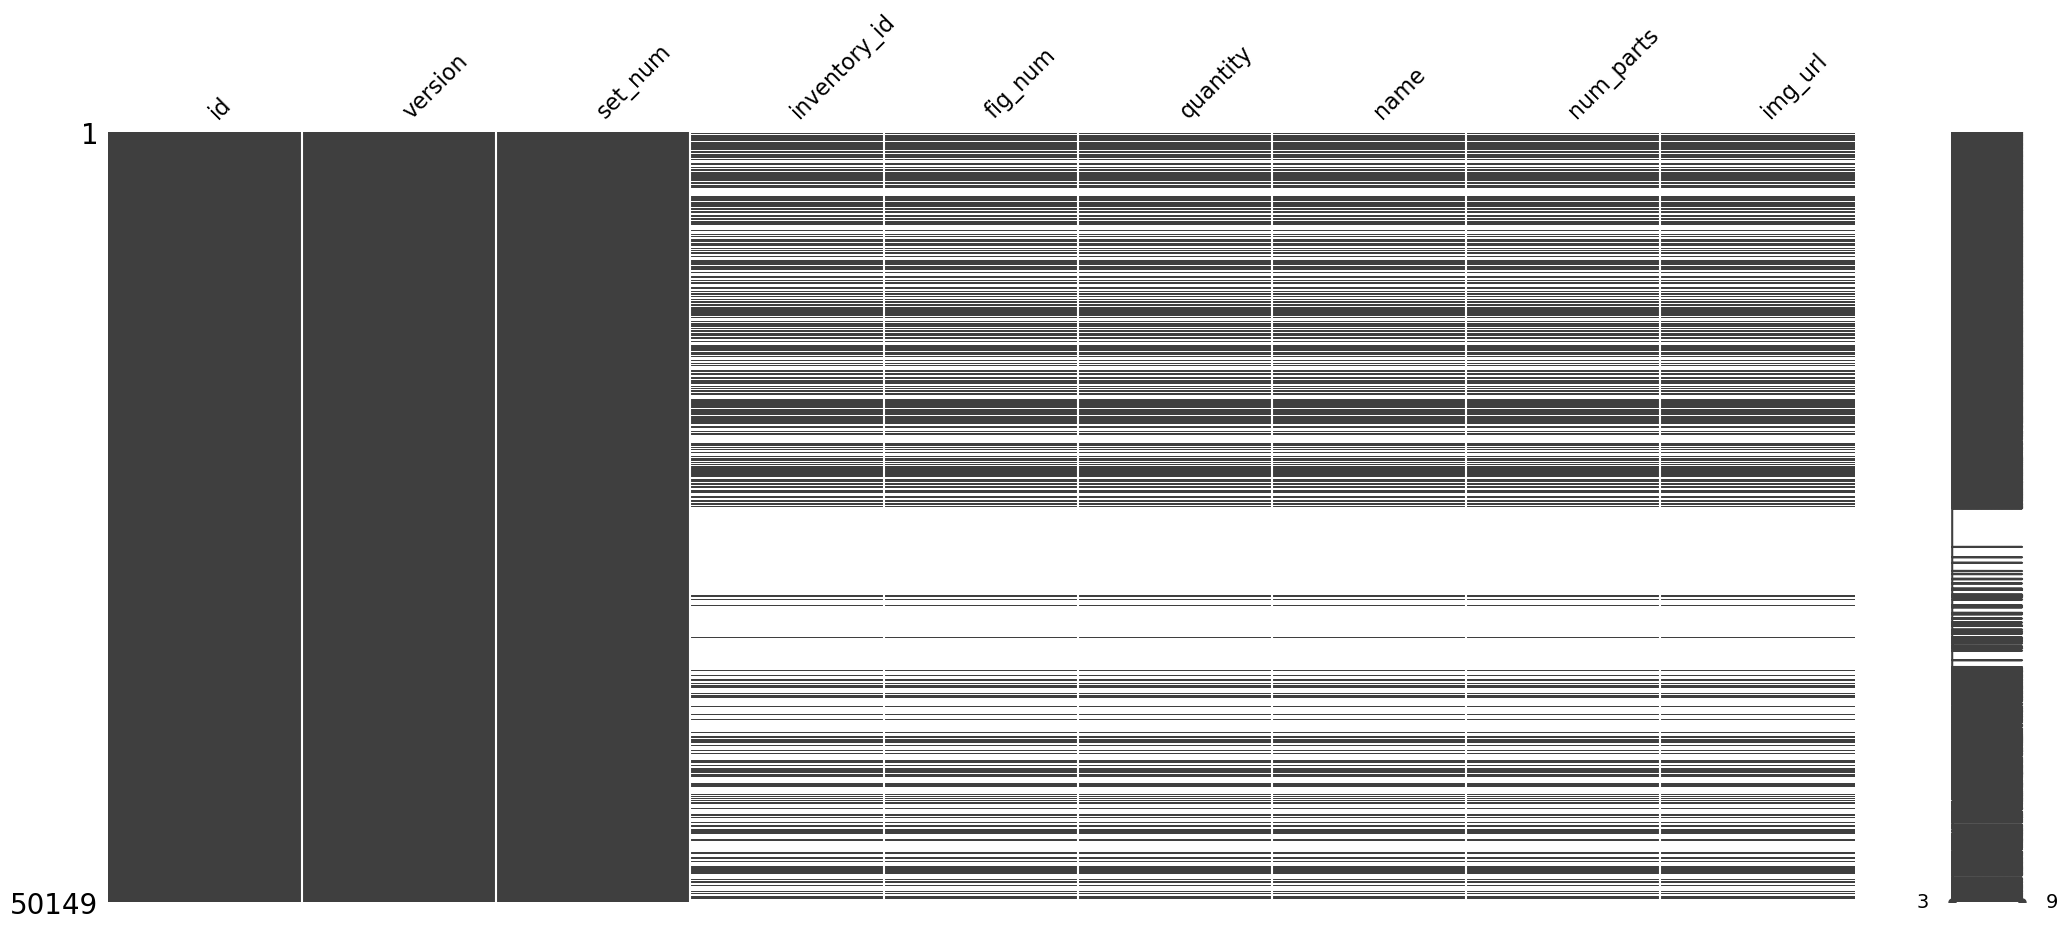

In [14]:
# clean and glimpse on 'inventories' and 'df_inventory_info'

#!pip install missingno 
import missingno as msno

df_inventories = pd.merge(dataset['inventories'], df_inventory_info, how = 'left', left_on = 'id', right_on = 'inventory_id')

display(df_inventories.head(10))
display(df_inventories.info())
msno.matrix(df_inventories)
print('\n')
display('number of unique inventory id', dataset['inventories'].id.nunique()
        , dataset['inventory_minifigs'].inventory_id.nunique()
        , dataset['inventory_parts'].inventory_id.nunique()
        , df_parts_info.inventory_id.nunique()
       )

In [15]:
#display(df_parts_info.head(),df_inventories.head(),df_inventories.shape)


In [16]:
PKL_DF_ALL = r'data/df_all.pkl'
with open(PKL_DF_ALL, 'wb') as file:
    pickle.dump(df_all, file)

In [17]:
data_path = os.path.join("data")
files = os.listdir(data_path)

files_csv = [f for f in files if f[-4:] == '.csv'] # find all files ending with '.csv'
display(files_csv)

dataset = {} 
for i in range(len(files_csv)):
    dataset[files_csv[i][:-4]] = load_csv_data(files_csv[i], data_path)

['colors.csv',
 'df_sets_new.csv',
 'df_sets_used.csv',
 'elements.csv',
 'inventories.csv',
 'inventory_minifigs.csv',
 'inventory_parts.csv',
 'inventory_sets.csv',
 'marketing price.csv',
 'minifigs.csv',
 'parts.csv',
 'part_categories.csv',
 'part_relationships.csv',
 'sets.csv',
 'themes.csv']

In [18]:
# Parts information: df_parts_info 
# inventory information: df_inventory_info
# Clean and merge 'inventory_minifigs', 'minifigs', 'part_categories', 'parts', 'inventory_parts' 



df_inventory_info = pd.merge(dataset['inventory_minifigs'], dataset['minifigs'], how = 'left', on = 'fig_num' )
#df_inventory_info.to_csv(r'D:\inven_info.csv')

df_parts = pd.merge(dataset['part_categories'], dataset['parts'], how = 'left', left_on = 'id', right_on = 'part_cat_id')
df_parts = df_parts.drop(columns = 'id')

df_parts = df_parts.merge(dataset['inventory_parts'], how = 'left', on = 'part_num')

df_parts_info = df_parts.rename(columns = {"name_x":"cat_name", "name_y":"part_name"})

del df_parts

display(df_inventory_info.head())
display(df_parts_info.head())


,inventory_id,fig_num,quantity,name,num_parts,img_url
0,3,fig-001549,1,"Emma - Lavender Top, Magenta Skirt",4,https://cdn.rebrickable.com/media/sets/fig-001...
1,4,fig-000764,1,Danny Longlegs / Corporal Steel,4,https://cdn.rebrickable.com/media/sets/fig-000...
2,19,fig-000555,1,Coca-Cola Defender 2,4,https://cdn.rebrickable.com/media/sets/fig-000...
3,25,fig-000574,1,Minnie Mouse with Dark Pink with White Spots D...,5,https://cdn.rebrickable.com/media/sets/fig-000...
4,26,fig-000842,1,"Coast Guard, Blue Jacket with Zipper and ID Ba...",4,https://cdn.rebrickable.com/media/sets/fig-000...


,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url
0,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
1,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
2,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
3,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
4,Baseplates,0903,Baseplate 16 x 24 with Set 080 Red House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...


## A primary merging and overviewing of dataset.
Some tables need to clean an update, this part is just a skeleton of data analysis. Datasets may need to update and re-process this part.

,id,version,set_num,fig_num,inv_quantity,name,num_parts_in_inv,inv_img_url
0,1,1,7922-1,NaN,NaN,NaN,NaN,NaN
1,3,1,3931-1,fig-001549,1.0,"Emma - Lavender Top, Magenta Skirt",4.0,https://cdn.rebrickable.com/media/sets/fig-001...
2,4,1,6942-1,fig-000764,1.0,Danny Longlegs / Corporal Steel,4.0,https://cdn.rebrickable.com/media/sets/fig-000...
3,15,1,5158-1,NaN,NaN,NaN,NaN,NaN
4,16,1,903-1,NaN,NaN,NaN,NaN,NaN
5,17,1,850950-1,NaN,NaN,NaN,NaN,NaN
6,19,1,4444-1,fig-000555,1.0,Coca-Cola Defender 2,4.0,https://cdn.rebrickable.com/media/sets/fig-000...
7,21,1,3474-1,NaN,NaN,NaN,NaN,NaN
8,22,1,30277-1,NaN,NaN,NaN,NaN,NaN
9,25,1,71012-11,fig-000574,1.0,Minnie Mouse with Dark Pink with White Spots D...,5.0,https://cdn.rebrickable.com/media/sets/fig-000...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50149 entries, 0 to 50148
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                50149 non-null  int64  
 1   version           50149 non-null  int64  
 2   set_num           50149 non-null  object 
 3   fig_num           20998 non-null  object 
 4   inv_quantity      20998 non-null  float64
 5   name              20998 non-null  object 
 6   num_parts_in_inv  20998 non-null  float64
 7   inv_img_url       20998 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB


None

'number of unique inventory id'

37554

8404

32519

32519

<Axes: >

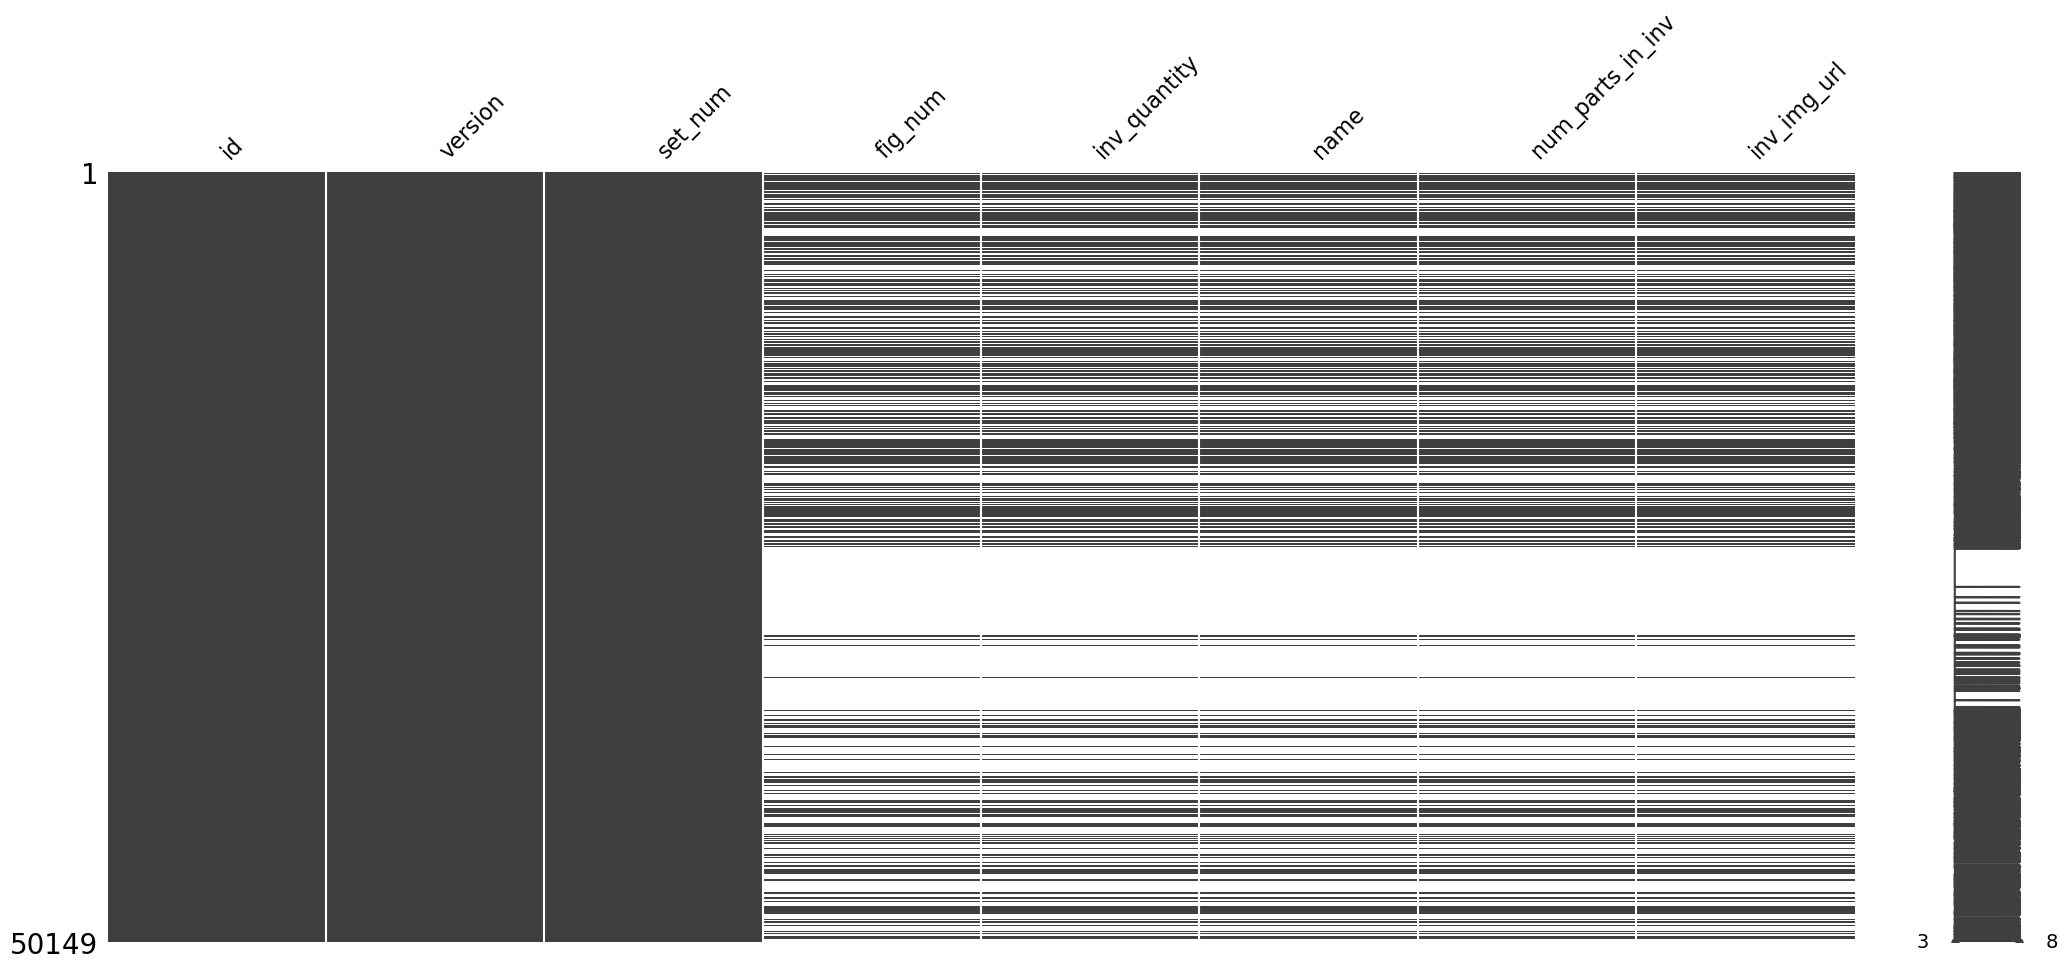

In [19]:
# clean and glimpse on 'inventories' and 'df_inventory_info'
# df_inventories  

df_inventories = pd.merge(dataset['inventories'], df_inventory_info, how = 'left', left_on = 'id', right_on = 'inventory_id')
df_inventories = df_inventories.drop(columns = 'inventory_id').rename(columns = {"quantity": "inv_quantity"
                                                                                 , "num_parts":"num_parts_in_inv"
                                                                                 , "img_url": "inv_img_url"  # from minifigs -> df_inventory_info -> df_inventories
                                                                                 })


display(df_inventories.head(10))
display(df_inventories.info())

print('\n')
display('number of unique inventory id', dataset['inventories'].id.nunique()
        , dataset['inventory_minifigs'].inventory_id.nunique()
        , dataset['inventory_parts'].inventory_id.nunique()
        , df_parts_info.inventory_id.nunique()
        , msno.matrix(df_inventories)
       )




In [20]:
# Parts information: df_parts_info 
# inventory information: df_inventory_info
# Clean and merge 'inventory_minifigs', 'minifigs', 'part_categories', 'parts', 'inventory_parts' 



df_inventory_info = pd.merge(dataset['inventory_minifigs'], dataset['minifigs'], how = 'left', on = 'fig_num' )
#df_inventory_info.to_csv(r'D:\inven_info.csv')

df_parts = pd.merge(dataset['part_categories'], dataset['parts'], how = 'left', left_on = 'id', right_on = 'part_cat_id')
df_parts = df_parts.drop(columns = 'id')

df_parts = df_parts.merge(dataset['inventory_parts'], how = 'left', on = 'part_num')

df_inv_part = df_parts.rename(columns = {"name_x":"cat_name", "name_y":"part_name"})

del df_parts

display(df_inventory_info.head())
display(df_inv_part.head())


,inventory_id,fig_num,quantity,name,num_parts,img_url
0,3,fig-001549,1,"Emma - Lavender Top, Magenta Skirt",4,https://cdn.rebrickable.com/media/sets/fig-001...
1,4,fig-000764,1,Danny Longlegs / Corporal Steel,4,https://cdn.rebrickable.com/media/sets/fig-000...
2,19,fig-000555,1,Coca-Cola Defender 2,4,https://cdn.rebrickable.com/media/sets/fig-000...
3,25,fig-000574,1,Minnie Mouse with Dark Pink with White Spots D...,5,https://cdn.rebrickable.com/media/sets/fig-000...
4,26,fig-000842,1,"Coast Guard, Blue Jacket with Zipper and ID Ba...",4,https://cdn.rebrickable.com/media/sets/fig-000...


,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url
0,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
1,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
2,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
3,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
4,Baseplates,0903,Baseplate 16 x 24 with Set 080 Red House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...


,id,version,set_num,fig_num,inv_quantity,name,num_parts_in_inv,inv_img_url
0,1,1,7922-1,NaN,NaN,NaN,NaN,NaN
1,3,1,3931-1,fig-001549,1.0,"Emma - Lavender Top, Magenta Skirt",4.0,https://cdn.rebrickable.com/media/sets/fig-001...
2,4,1,6942-1,fig-000764,1.0,Danny Longlegs / Corporal Steel,4.0,https://cdn.rebrickable.com/media/sets/fig-000...


,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url
0,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
1,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...
2,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...


,id,version,set_num,fig_num,inv_quantity,name,num_parts_in_inv,inv_img_url,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url
0,1,1,7922-1,NaN,NaN,NaN,NaN,NaN,Minifigs,upn0350,Sports Promo Figure Head Torso Assembly McDona...,13.0,Plastic,1.0,25.0,1.0,f,NaN
1,1,1,7922-1,NaN,NaN,NaN,NaN,NaN,Minifig Accessories,48395,Sports Snowboard from McDonald's Promotional Set,27.0,Plastic,1.0,7.0,1.0,f,https://cdn.rebrickable.com/media/parts/photos...
2,1,1,7922-1,NaN,NaN,NaN,NaN,NaN,Minifig Accessories,upn0342,Sports Promo Paddle from McDonald's Sports Sets,27.0,Plastic,1.0,0.0,1.0,f,https://cdn.rebrickable.com/media/parts/photos...
3,1,1,7922-1,NaN,NaN,NaN,NaN,NaN,Large Buildable Figures,48379c04,"Large Figure Torso and Legs, with Black Feet",41.0,Plastic,1.0,72.0,1.0,f,https://cdn.rebrickable.com/media/parts/photos...
4,1,1,7922-1,NaN,NaN,NaN,NaN,NaN,Stickers,stickerupn0077,Sticker Sheet for Set 7922-1,58.0,Plastic,1.0,9999.0,1.0,f,NaN
5,3,1,3931-1,fig-001549,1.0,"Emma - Lavender Top, Magenta Skirt",4.0,https://cdn.rebrickable.com/media/sets/fig-001...,Bricks Sloped,3039,Slope 45° 2 x 2,3.0,Plastic,3.0,15.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...
6,3,1,3931-1,fig-001549,1.0,"Emma - Lavender Top, Magenta Skirt",4.0,https://cdn.rebrickable.com/media/sets/fig-001...,Bricks,3003,Brick 2 x 2,11.0,Plastic,3.0,29.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...
7,3,1,3931-1,fig-001549,1.0,"Emma - Lavender Top, Magenta Skirt",4.0,https://cdn.rebrickable.com/media/sets/fig-001...,Plates,3020,Plate 2 x 4,14.0,Plastic,3.0,15.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...
8,3,1,3931-1,fig-001549,1.0,"Emma - Lavender Top, Magenta Skirt",4.0,https://cdn.rebrickable.com/media/sets/fig-001...,Plates,3022,Plate 2 x 2,14.0,Plastic,3.0,15.0,2.0,f,https://cdn.rebrickable.com/media/parts/elemen...
9,3,1,3931-1,fig-001549,1.0,"Emma - Lavender Top, Magenta Skirt",4.0,https://cdn.rebrickable.com/media/sets/fig-001...,Plates,3023,Plate 1 x 2,14.0,Plastic,3.0,15.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...


(3773913, 18)

<Axes: >

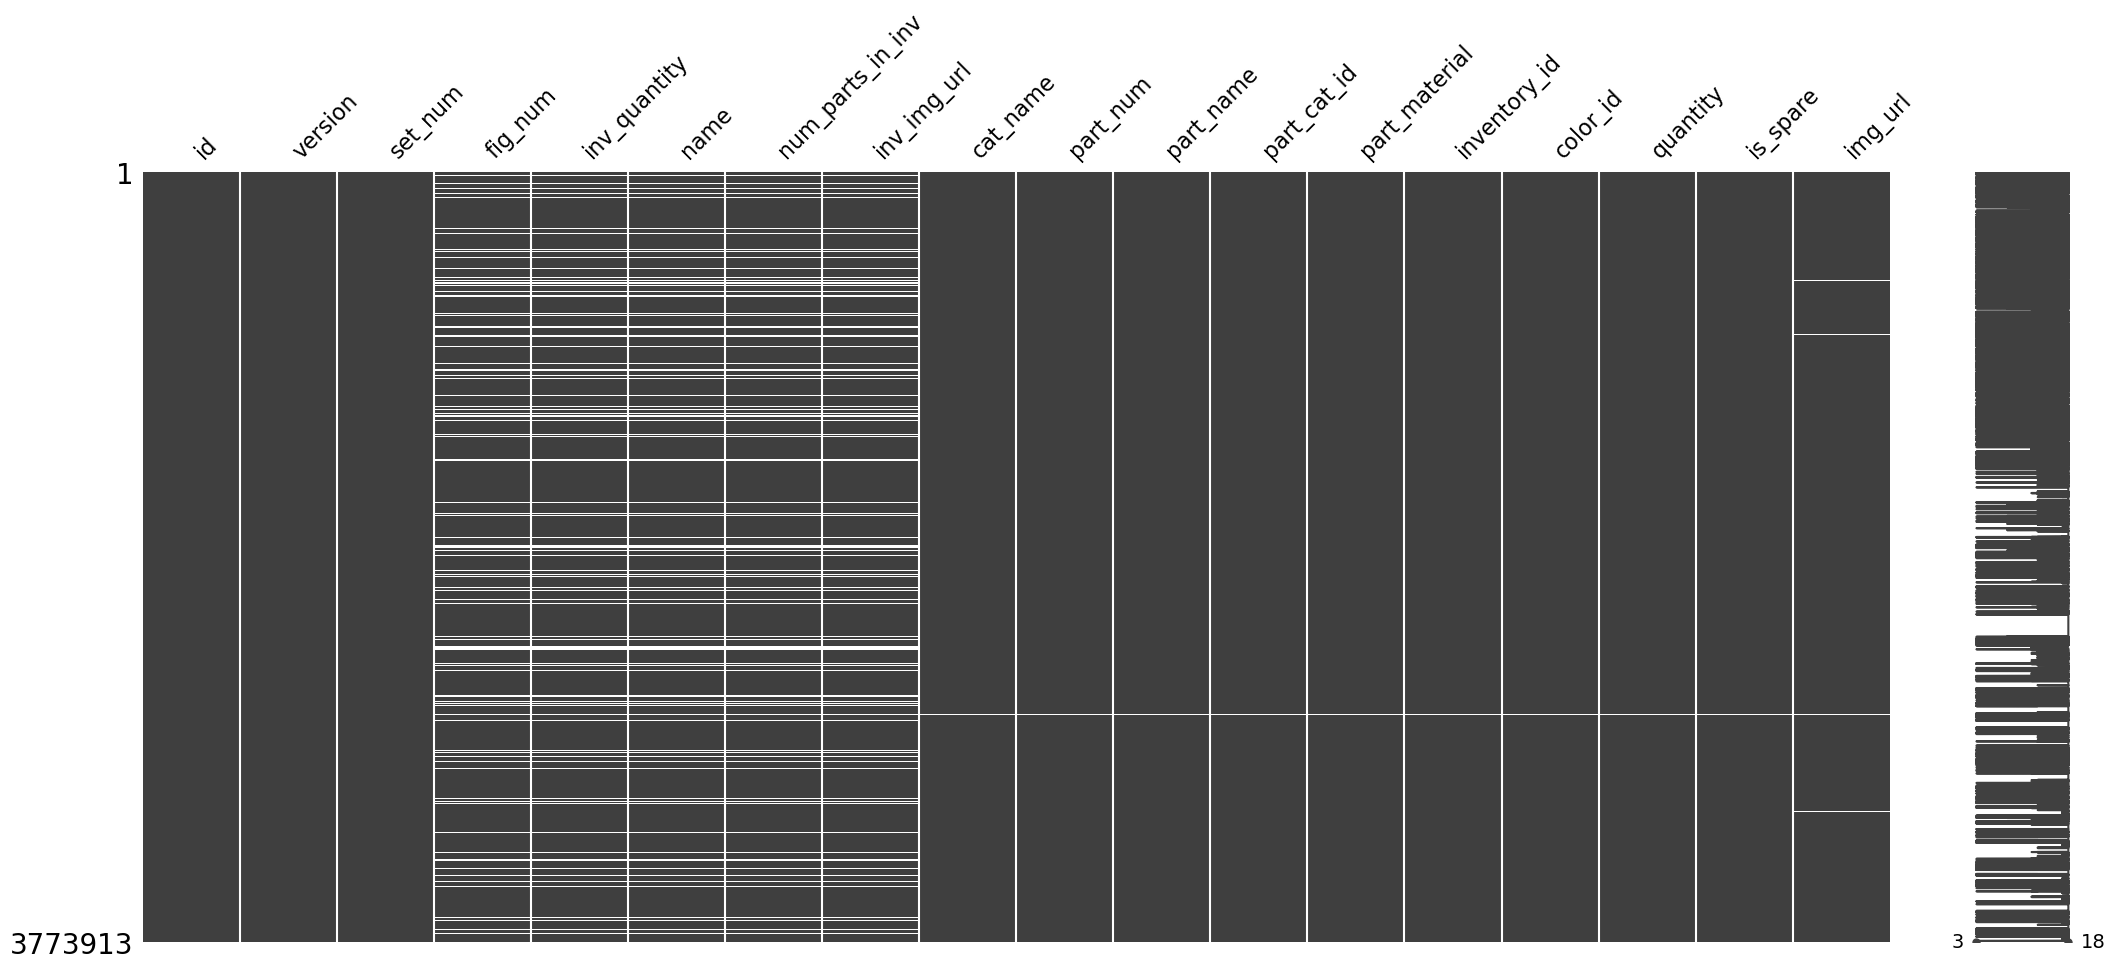

In [21]:
# merge inventories and parts
# df_inventory_all


df_inventory_all = pd.merge(df_inventories, df_inv_part, how = 'left', left_on = 'id', right_on = 'inventory_id')
display(df_inventories.head(3)
        , df_inv_part.head(3)
        , df_inventory_all.head(10)
        , df_inventory_all.shape
        , msno.matrix(df_inventory_all)
       )

In [22]:
# wrangle df_inv_concat
temp = dataset['inventories'].copy()
temp.version = np.NaN
temp = temp.rename(columns = {'version':'quantity', 'id':'inventory_id'})
temp = temp[['inventory_id', 'set_num', 'quantity']]
df_inv_concat = pd.concat([temp, dataset['inventory_sets']], ignore_index=True).sort_values(by = 'set_num').reset_index()
df_inv_concat.loc[df_inv_concat['quantity'].isna(),'quantity'] = 1.0
del temp


# save to file
data_to_save = (dataset, df_inv_concat, df_parts_info, df_inventory_info)

with open(PKL_FILENAME, 'wb') as file:
    pickle.dump(data_to_save, file)


## color process

In [23]:

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    # color to rgb
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return r, g, b

def rgb_to_hsv(rgb_color):
    r, g, b = rgb_color
    hsv_color = colorsys.rgb_to_hsv(r / 255.0, g / 255.0, b / 255.0)
    return hsv_color


df_colors = dataset['colors'].copy()
df_colors['rgb_colors'] = df_colors['rgb'].apply(hex_to_rgb)
df_colors['hsv_colors'] = df_colors['rgb_colors'].apply(rgb_to_hsv)
df_colors.head(3)






,id,name,rgb,is_trans,rgb_colors,hsv_colors
0,-1,[Unknown],0033B2,f,"(0, 51, 178)","(0.6189138576779026, 1.0, 0.6980392156862745)"
1,0,Black,05131D,f,"(5, 19, 29)","(0.5694444444444445, 0.8275862068965517, 0.113..."
2,1,Blue,0055BF,f,"(0, 85, 191)","(0.5924956369982549, 1.0, 0.7490196078431373)"


C:\Users\niels\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\niels\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



,cluster_labels,cluster_hsv,cluster_rgb
0,0,"(0.13247603549152825, 0.7856281175779112, 0.92...","[0.9202941176470588, 0.7719733265951909, 0.197..."
1,1,"(0.5594319522831701, 0.8236014143890347, 0.624...","[0.11012805815398304, 0.4409593772153012, 0.62..."
2,2,"(0.5147000403428982, 0.32692240152809643, 0.75...","[0.5104028336238348, 0.7364463701731263, 0.758..."


,id,name,rgb,is_trans,rgb_colors,hsv_colors,cluster_labels,H,S,V,cluster_hsv,cluster_rgb
0,-1,[Unknown],0033B2,f,"(0, 51, 178)","(0.6189138576779026, 1.0, 0.6980392156862745)",1,0.618914,1.000000,0.698039,"(0.5594319522831701, 0.8236014143890347, 0.624...","[0.11012805815398304, 0.4409593772153012, 0.62..."
1,0,Black,05131D,f,"(5, 19, 29)","(0.5694444444444445, 0.8275862068965517, 0.113...",4,0.569444,0.827586,0.113725,"(0.33168861207051414, 0.7713588535376217, 0.41...","[0.09704247787324882, 0.4107563025210085, 0.09..."
2,1,Blue,0055BF,f,"(0, 85, 191)","(0.5924956369982549, 1.0, 0.7490196078431373)",1,0.592496,1.000000,0.749020,"(0.5594319522831701, 0.8236014143890347, 0.624...","[0.11012805815398304, 0.4409593772153012, 0.62..."


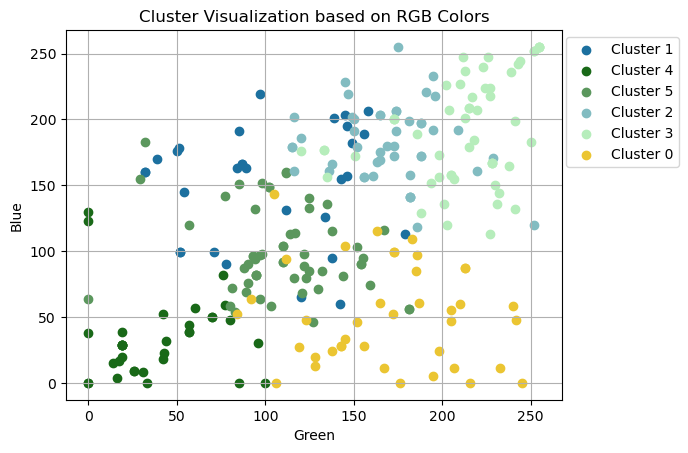

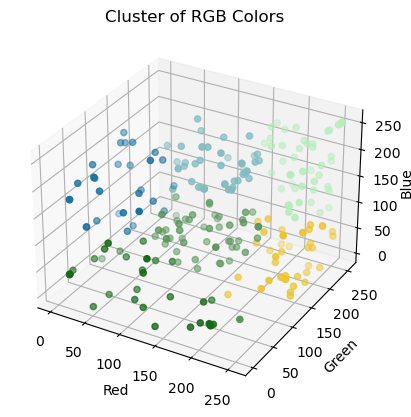

In [24]:
K = 6 

color_features = df_colors['rgb_colors'].tolist()


# K-means for colors
kmeans = KMeans(n_clusters=K)
kmeans.fit(color_features)
color_labels = kmeans.labels_
df_colors['cluster_labels'] = color_labels
df = df_colors
df['H'] = df['hsv_colors'].apply(lambda x: x[0])
df['S'] = df['hsv_colors'].apply(lambda x: x[1])
df['V'] = df['hsv_colors'].apply(lambda x: x[2])

#Visualization   mean color 
cluster_means = df.groupby('cluster_labels')['hsv_colors'].agg(lambda x: tuple(x)).reset_index()
cluster_means['hsv_colors'] = cluster_means['hsv_colors'].apply(lambda x: tuple(map(lambda y: sum(y) / len(y), zip(*x))))

# HSV to RGB
cluster_means['rgb_colors'] = cluster_means['hsv_colors'].apply(lambda hsv: hsv_to_rgb(hsv))
cluster_means.rename(columns = {'hsv_colors':'cluster_hsv','rgb_colors':'cluster_rgb'},inplace = True)
df = df.merge(cluster_means, how = 'left',on = 'cluster_labels')
cluster_means
display(cluster_means.head(3),df.head(3))

df['R'] = df['rgb_colors'].apply(lambda x: x[0])
df['G'] = df['rgb_colors'].apply(lambda x: x[1])
df['B'] = df['rgb_colors'].apply(lambda x: x[2])

for cluster_label in df['cluster_labels'].unique():
    cluster_data = df[df['cluster_labels'] == cluster_label]
    rgb_color = cluster_means[cluster_means['cluster_labels'] == cluster_label]['cluster_rgb']
    plt.scatter(cluster_data['G'], cluster_data['B'], c=list(rgb_color), label=f'Cluster {cluster_label}')

plt.xlabel('Green')
plt.ylabel('Blue')
plt.title('Cluster Visualization based on RGB Colors')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.grid(True)
plt.show()


# Visualization  3D scatter
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for cluster_label in df['cluster_labels'].unique():
    cluster_data = df[df['cluster_labels'] == cluster_label]
    rgb_color = cluster_means[cluster_means['cluster_labels'] == cluster_label]['cluster_rgb']
    ax.scatter(cluster_data['R'], cluster_data['G'], cluster_data['B'], c=list(rgb_color))
    
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue',labelpad=0,rotation=90)
plt.title('Cluster of RGB Colors')
plt.show()

In [25]:
#K = K

color_features = df_colors['hsv_colors'].tolist()
#color_features = df_colors['rgb_colors'].tolist()
#color_features = df_colors[['H', 'V']].values

kmeans = KMeans(n_clusters=K)
kmeans.fit(color_features)
color_labels = kmeans.labels_

df_colors['cluster_labels'] = color_labels

df = df_colors

df['H'] = df['hsv_colors'].apply(lambda x: x[0])
df['S'] = df['hsv_colors'].apply(lambda x: x[1])
df['V'] = df['hsv_colors'].apply(lambda x: x[2])


C:\Users\niels\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\niels\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [26]:
#Visualization   mean color 
# mean HSV for cluster
cluster_means = df.groupby('cluster_labels')['hsv_colors'].agg(lambda x: tuple(x)).reset_index()
cluster_means['hsv_colors'] = cluster_means['hsv_colors'].apply(lambda x: tuple(map(lambda y: sum(y) / len(y), zip(*x))))

# HSV to RGB
cluster_means['rgb_colors'] = cluster_means['hsv_colors'].apply(lambda hsv: hsv_to_rgb(hsv))
cluster_means.rename(columns = {'hsv_colors':'cluster_hsv','rgb_colors':'cluster_rgb'},inplace = True)
df = df.merge(cluster_means, how = 'left',on = 'cluster_labels')
cluster_means
display(cluster_means.head(3),df.head(3))

,cluster_labels,cluster_hsv,cluster_rgb
0,0,"(0.44369781738129827, 0.7827298301786849, 0.27...","[0.05985580168606818, 0.2754901960784314, 0.20..."
1,1,"(0.6584570883795113, 0.8668157576942974, 0.679...","[0.09045133033595847, 0.11944886065348985, 0.6..."
2,2,"(0.16148968979266154, 0.21898550660213878, 0.8...","[0.8869875222816397, 0.880954146744286, 0.6927..."


,id,name,rgb,is_trans,rgb_colors,hsv_colors,cluster_labels,H,S,V,cluster_hsv,cluster_rgb
0,-1,[Unknown],0033B2,f,"(0, 51, 178)","(0.6189138576779026, 1.0, 0.6980392156862745)",1,0.618914,1.000000,0.698039,"(0.6584570883795113, 0.8668157576942974, 0.679...","[0.09045133033595847, 0.11944886065348985, 0.6..."
1,0,Black,05131D,f,"(5, 19, 29)","(0.5694444444444445, 0.8275862068965517, 0.113...",0,0.569444,0.827586,0.113725,"(0.44369781738129827, 0.7827298301786849, 0.27...","[0.05985580168606818, 0.2754901960784314, 0.20..."
2,1,Blue,0055BF,f,"(0, 85, 191)","(0.5924956369982549, 1.0, 0.7490196078431373)",1,0.592496,1.000000,0.749020,"(0.6584570883795113, 0.8668157576942974, 0.679...","[0.09045133033595847, 0.11944886065348985, 0.6..."


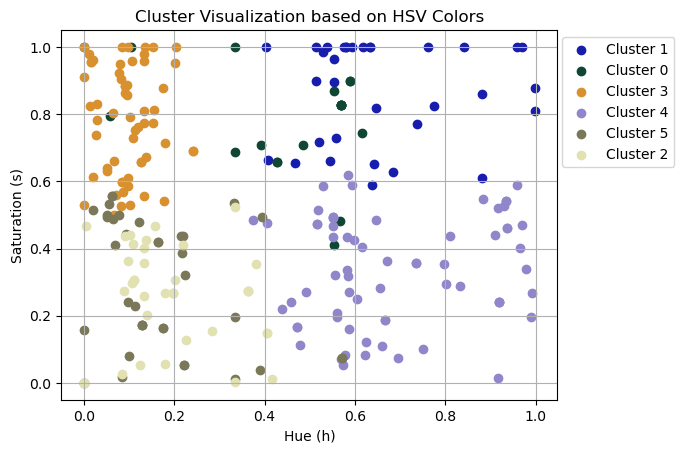

In [27]:
for cluster_label in df['cluster_labels'].unique():
    cluster_data = df[df['cluster_labels'] == cluster_label]
    rgb_color = cluster_means[cluster_means['cluster_labels'] == cluster_label]['cluster_rgb']
    plt.scatter(cluster_data['H'], cluster_data['S'], c=list(rgb_color), label=f'Cluster {cluster_label}')

plt.xlabel('Hue (h)')
plt.ylabel('Saturation (s)')
plt.title('Cluster Visualization based on HSV Colors')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.grid(True)
plt.show()

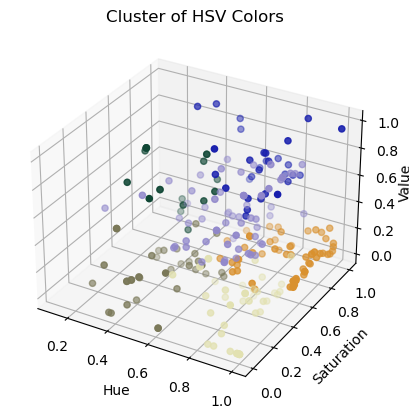

In [28]:
# Visualization  3D scatter
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for cluster_label in df['cluster_labels'].unique():
    cluster_data = df[df['cluster_labels'] == cluster_label]
    rgb_color = cluster_means[cluster_means['cluster_labels'] == cluster_label]['cluster_rgb']
    ax.scatter(cluster_data['V'], cluster_data['S'], cluster_data['H'], c=list(rgb_color))
    
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value',labelpad=-0.5,rotation=90)
plt.title('Cluster of HSV Colors')
plt.show()


In [29]:
display(
    df.head(3)
    ,df_colors.head(3)
    ,(df.shape, df_colors.shape)
)
df_colors = df 
del df

,id,name,rgb,is_trans,rgb_colors,hsv_colors,cluster_labels,H,S,V,cluster_hsv,cluster_rgb
0,-1,[Unknown],0033B2,f,"(0, 51, 178)","(0.6189138576779026, 1.0, 0.6980392156862745)",1,0.618914,1.000000,0.698039,"(0.6584570883795113, 0.8668157576942974, 0.679...","[0.09045133033595847, 0.11944886065348985, 0.6..."
1,0,Black,05131D,f,"(5, 19, 29)","(0.5694444444444445, 0.8275862068965517, 0.113...",0,0.569444,0.827586,0.113725,"(0.44369781738129827, 0.7827298301786849, 0.27...","[0.05985580168606818, 0.2754901960784314, 0.20..."
2,1,Blue,0055BF,f,"(0, 85, 191)","(0.5924956369982549, 1.0, 0.7490196078431373)",1,0.592496,1.000000,0.749020,"(0.6584570883795113, 0.8668157576942974, 0.679...","[0.09045133033595847, 0.11944886065348985, 0.6..."


,id,name,rgb,is_trans,rgb_colors,hsv_colors,cluster_labels,H,S,V
0,-1,[Unknown],0033B2,f,"(0, 51, 178)","(0.6189138576779026, 1.0, 0.6980392156862745)",1,0.618914,1.000000,0.698039
1,0,Black,05131D,f,"(5, 19, 29)","(0.5694444444444445, 0.8275862068965517, 0.113...",0,0.569444,0.827586,0.113725
2,1,Blue,0055BF,f,"(0, 85, 191)","(0.5924956369982549, 1.0, 0.7490196078431373)",1,0.592496,1.000000,0.749020


((263, 12), (263, 10))

In [30]:
#if True:
if False:
    all_variables = dict(locals())
    for variable_name, variable_value in all_variables.items():
        if variable_name[:2] == 'df':
            print(f"{variable_name}")




In [31]:
data_to_save = (dataset, df_inv_concat, df_parts_info, df_inventory_info, df_colors)

with open(PKL_FILENAME2, 'wb') as file:
    pickle.dump(data_to_save, file)


In [32]:
with open(PKL_FILENAME2, 'rb') as file:
    loaded_data = pickle.load(file)

# load variables
# (dataset, df_inv_concat, df_parts_info, df_inventory_info, df_colors) = loaded_data

## shape of parts

In [33]:
df_parts_info['part_name'].unique()[80:90]

array(['Baseplate 24 x 40', 'Baseplate 24 x 40 with Set 369 Dots Print',
       'Baseplate 24 x 40 with Set 370 Dots Print',
       'Baseplate 24 x 40 with Set 373 Dots Print',
       'Baseplate 24 x 24 with Studs on Edges', 'Baseplate 24 x 24',
       'Baseplate 16 x 32 with Rounded Corners [Plain]',
       'Baseplate 16 x 32 with Rounded Corners and Dots Print [350 / 540-3]',
       'Baseplate 16 x 32 with Rounded Corners and Dots Print [352]',
       'Baseplate 16 x 32 with Rounded Corners and Set 356 Dots Print'],
      dtype=object)

In [34]:
# Regular expression to extract part size
pattern = r'(\d+(\s*x\s*\d+\s*)+)'

# extract part_shape 
df_parts_info['part_shape'] = df_parts_info['part_name'].str.extract(pattern).iloc[:, 0]
# calculate part_size
df_parts_info['part_size'] = df_parts_info['part_shape'].str.replace('x', '*').fillna('0')
df_parts_info['part_size'] = df_parts_info['part_size'].str.replace(' ', '').apply(eval)


In [35]:
display(
    df_parts_info.head(3)
    , df_parts_info.groupby('part_shape').size().reset_index(name='count').sort_values(by = 'count',ascending = False)[:5]
    , df_parts_info.groupby('part_size').size().reset_index(name='count').sort_values(by = 'part_size')[:5]
    , df_parts_info[df_parts_info['part_size'] == 0]['part_name'][:5]
    , df_parts_info.shape
    )


,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url,part_shape,part_size
0,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,16 x 30,480
1,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,16 x 30,480
2,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,16 x 24,384


,part_shape,count
4,1 x 1,119794
42,1 x 2,105576
414,2 x 2,90045
3,1 x 1,37344
41,1 x 2,36011


,part_size,count
0,0,297703
1,1,159800
2,2,189096
3,3,28763
4,4,195130


242     Baseplate Raised with Steps and Pool Print
936                 Baseplate Sea Floor Play Stage
937            Baseplate Raised Cave without Studs
1076               Baseplate Sports Soccer Stadium
1077               Baseplate Sports Soccer Stadium
Name: part_name, dtype: object

(1188803, 12)

In [36]:
#msno.matrix(df_parts_info)
# remove parent sets in df_parts_info, as they are composed of other parts, leading to redundancy during feature extraction.
parent_parts = dataset['part_relationships']['parent_part_num'].unique()
df_parts_info_all = df_parts_info
df_parts_info = df_parts_info[~df_parts_info['part_num'].isin(parent_parts)]


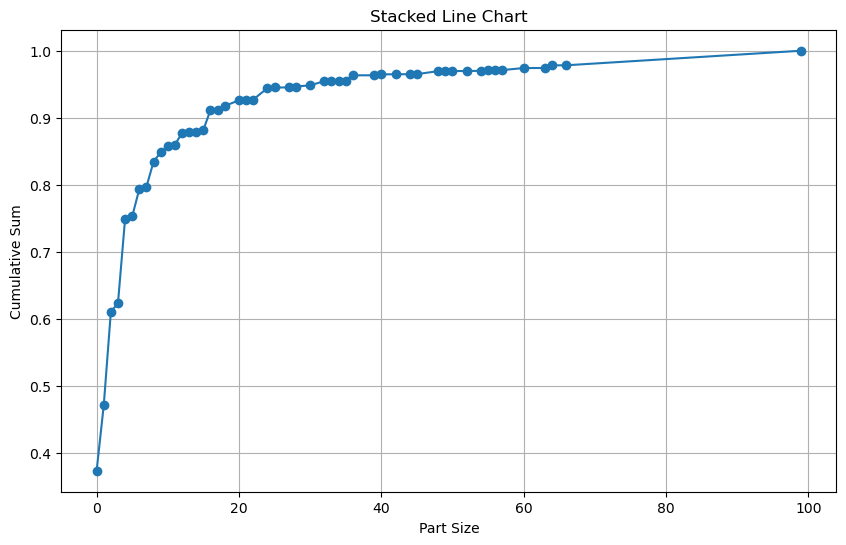

In [37]:
df_parts_overview = df_parts_info.groupby('part_size').size().reset_index(name='count').sort_values(by = 'part_size')[:49]
value_other = df_parts_info.groupby('part_size').size().reset_index(name='count').sort_values(by = 'part_size')['count'][49:].sum()
df_parts_overview.loc[len(df_parts_overview)] = {'part_size': 99, 'count': value_other}
df_parts_overview['cumulative_sum'] = df_parts_overview['count'].cumsum()

# stacked plot
plt.figure(figsize=(10, 6))
plt.plot(df_parts_overview['part_size'], df_parts_overview['cumulative_sum']/df_parts_overview['cumulative_sum'].iloc[-1]
         , marker='o', linestyle='-')
plt.xlabel('Part Size')
plt.ylabel('Cumulative Sum')
plt.title('Stacked Line Chart')
plt.grid(True)
plt.show()



In [38]:
display(
    df_parts_info.head(2)
    ,df_inventory_info.head(2)
)

,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url,part_shape,part_size
0,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,16 x 30,480
1,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,16 x 30,480


,inventory_id,fig_num,quantity,name,num_parts,img_url
0,3,fig-001549,1,"Emma - Lavender Top, Magenta Skirt",4,https://cdn.rebrickable.com/media/sets/fig-001...
1,4,fig-000764,1,Danny Longlegs / Corporal Steel,4,https://cdn.rebrickable.com/media/sets/fig-000...


In [39]:
display(    
    df_parts_info.inventory_id.nunique()
    ,df_inventory_info.inventory_id.nunique()
    ,df_parts_info.groupby('inventory_id').size().reset_index(name='count')[12:15]
    ,df_inventory_info.groupby('inventory_id').size().reset_index(name='count')[8:10]
    ,df_inventory_info[df_inventory_info['inventory_id'] == 33]
    ,df_parts_info[df_parts_info['inventory_id'] == 33].head(3)
)



31371

8404

,inventory_id,count
12,33.0,19
13,34.0,1
14,36.0,2


,inventory_id,count
8,33,3
9,34,1


,inventory_id,fig_num,quantity,name,num_parts,img_url
16,33,fig-008216,1,"Woman, Blue Torso, Light Gray Legs, Black Hair",4,https://cdn.rebrickable.com/media/sets/fig-008...
17,33,fig-008217,1,"Doctor, White Jacket with Red Cross, Red Legs,...",4,https://cdn.rebrickable.com/media/sets/fig-008...
18,33,fig-008218,1,"Pilot, Black Suit with Tie and Airplane Badge,...",4,https://cdn.rebrickable.com/media/sets/fig-008...


,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url,part_shape,part_size
14253,Bricks Sloped,3039pr9970,Slope 45° 2 x 2 with 3 Gauges and 3 Knobs Print,3,Plastic,33.0,0.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,2 x 2,4
34746,Bricks Sloped,3676,Slope Inverted 45° 2 x 2 Double Convex,3,Plastic,33.0,15.0,2.0,f,https://cdn.rebrickable.com/media/parts/elemen...,2 x 2,4
378209,Plates,2420,Plate 2 x 2 Corner,14,Plastic,33.0,4.0,4.0,f,https://cdn.rebrickable.com/media/parts/elemen...,2 x 2,4


In [40]:
display(
    df_inv_concat[df_inv_concat['inventory_id'] == 33]
    ,dataset['sets'][dataset['sets']['set_num'] == '6356-1' ] 
)

,index,inventory_id,set_num,quantity
14795,15,33,6356-1,1.0


,set_num,name,year,theme_id,num_parts,img_url
12070,6356-1,Med-Star Rescue Plane,1988,67,160,https://cdn.rebrickable.com/media/sets/6356-1.jpg


In [41]:
# inventory features

In [42]:
df_inventory_info['num_parts_all'] = df_inventory_info['num_parts'] * df_inventory_info['quantity']  
df_inventory_grp = df_inventory_info.groupby('inventory_id').agg({'quantity': ['sum','count'], 'num_parts': 'sum'}).reset_index()
df_inventory_grp[df_inventory_grp['quantity']['sum'] != df_inventory_grp['quantity']['count']]
#temp.columns = temp.columns.map(lambda x: '_'.join(x) if x != ('inventory_id','') else 'inventory_id')
df_inventory_grp.columns = ['inventory_id','unique_minifigs','num_minifigs','parts_minifigs']
df_inventory_grp

,inventory_id,unique_minifigs,num_minifigs,parts_minifigs
0,3,1,1,4
1,4,1,1,4
2,19,1,1,4
3,25,1,1,5
4,26,6,6,28
...,...,...,...,...
8399,198658,1,1,5
8400,198849,1,1,5
8401,199104,1,1,4
8402,199402,1,1,5


In [43]:
# merge df_parts_info and color

df_parts_info.head(3)    # join color  
df_colors.rename(columns = {'id':'color_id','name':'color_name'},inplace = True)
df_colors[['color_id','rgb','color_name','cluster_labels','cluster_rgb']]


common_colors = ['05131D' ,'FFFFFF' ,'A0A5A9' ,'C91A09' ,'6C6E68' ,'F2CD37' ,'0055BF' ,'582A12' ,'E4CD9E' ,'9BA19D']
#df_colors[df_color[]]
df_colors.loc[df_colors['rgb'].isin(common_colors),['cluster_hsv','cluster_labels','cluster_rgb']] = ['','-1','']

if 'rgb' not in df_parts_info.columns:
    df_parts_info = df_parts_info.merge(df_colors[['color_id','rgb','color_name','cluster_labels','cluster_rgb']], how = 'left', on = 'color_id')
    df_parts_info.rename(columns={'cluster_labels':'color_cluster_labels'},inplace = True)



In [44]:
df_parts_freq = df_parts_info.groupby('part_num')['quantity'].sum().sort_values(ascending = False)
quantity_sum = df_parts_freq.sum()
df_parts_freq = pd.DataFrame(df_parts_freq)
df_parts_freq = df_parts_freq[df_parts_freq['quantity'] >= 1].reset_index()
df_parts_freq['freq'] = df_parts_freq['quantity']/quantity_sum * 100
df_parts_freq['cumsum'] = df_parts_freq['freq'].cumsum()
#display(df_parts_freq[:3],df_parts_freq[-3:],df_parts_freq[38:40],  df_parts_freq[93:95], df_parts_freq[215:217])
df_parts_freq['rarity'] = 'moderate'
df_parts_freq.loc[df_parts_freq['cumsum'] >= 66.6666, 'rarity']  = 'rare'
df_parts_freq.loc[df_parts_freq['cumsum'] <= 33.3333, 'rarity'] = 'common'
df_parts_freq.head(3)

,part_num,quantity,freq,cumsum,rarity
0,3022,44209.0,2.908695,2.908695,common
1,3021,35080.0,2.308060,5.216756,common
2,2412b,31602.0,2.079228,7.295984,common


In [45]:

df_parts_info = df_parts_info.merge(df_parts_freq[['part_num','freq','rarity']], on = 'part_num', how = 'left')
df_parts_info.head(3)

,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url,part_shape,part_size,rgb,color_name,color_cluster_labels,cluster_rgb,freq,rarity
0,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,16 x 30,480,237841,Green,0,"[0.05985580168606818, 0.2754901960784314, 0.20...",0.000132,rare
1,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,16 x 30,480,237841,Green,0,"[0.05985580168606818, 0.2754901960784314, 0.20...",0.000132,rare
2,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,16 x 24,384,237841,Green,0,"[0.05985580168606818, 0.2754901960784314, 0.20...",0.000132,rare


In [46]:
# df_parts_info feature selection
df_parts_info['small_part'] = np.where((df_parts_info['part_size'] >= 1) & (df_parts_info['part_size'] <= 2), df_parts_info['quantity'], 0)
df_parts_info['medium_part'] = np.where((df_parts_info['part_size'] >= 3) & (df_parts_info['part_size'] <= 7), df_parts_info['quantity'], 0)
df_parts_info['large_part'] = np.where(df_parts_info['part_size'] >= 8, df_parts_info['quantity'], 0)
df_parts_info['non_size_part'] = np.where(df_parts_info['part_size'] == 0, df_parts_info['quantity'], 0)
df_parts_info.head(3)



,cat_name,part_num,part_name,part_cat_id,part_material,inventory_id,color_id,quantity,is_spare,img_url,...,rgb,color_name,color_cluster_labels,cluster_rgb,freq,rarity,small_part,medium_part,large_part,non_size_part
0,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,...,237841,Green,0,"[0.05985580168606818, 0.2754901960784314, 0.20...",0.000132,rare,0.0,0.0,1.0,0.0
1,Baseplates,0901,Baseplate 16 x 30 with Set 080 Yellow House Print,1,Plastic,24756.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,...,237841,Green,0,"[0.05985580168606818, 0.2754901960784314, 0.20...",0.000132,rare,0.0,0.0,1.0,0.0
2,Baseplates,0902,Baseplate 16 x 24 with Set 080 Small White Hou...,1,Plastic,1973.0,2.0,1.0,f,https://cdn.rebrickable.com/media/parts/ldraw/...,...,237841,Green,0,"[0.05985580168606818, 0.2754901960784314, 0.20...",0.000132,rare,0.0,0.0,1.0,0.0


In [47]:
# spare parts and not spare parts
# NaN value will be removed. 
temp_parts_spare = df_parts_info[df_parts_info['is_spare'] == 't']
temp_parts_not_spare = df_parts_info[df_parts_info['is_spare'] == 'f']

In [48]:

group_inventory = temp_parts_not_spare.groupby('inventory_id').agg(
    {'color_id': ['nunique', ('mode', lambda x: x.mode().iloc[0])]
     , 'color_cluster_labels': ['nunique', ('mode', lambda x: x.mode().iloc[0])]
     , 'part_num':['nunique'], 'small_part':'sum', 'medium_part':'sum', 'large_part':'sum','non_size_part' : 'sum'
     , 'quantity':'sum'
    }).reset_index()

group_inventory_spare = temp_parts_spare.groupby('inventory_id').agg(
    {'color_id': ['nunique', ('mode', lambda x: x.mode().iloc[0])]
     , 'color_cluster_labels': ['nunique', ('mode', lambda x: x.mode().iloc[0])]
     , 'part_num':['nunique'], 'small_part':'sum', 'medium_part':'sum', 'large_part':'sum','non_size_part' : 'sum'
     , 'quantity':'sum'
    }).reset_index()



#temp_parts_not_pare
group_inventory.columns = group_inventory.columns.map(lambda x: '_'.join(x) if x != ('inventory_id','') else 'inventory_id')
group_inventory.head(3)

C:\Users\niels\AppData\Local\Temp\ipykernel_18844\3096943830.py:3: UserWarning:

Unable to sort modes: '<' not supported between instances of 'int' and 'str'

C:\Users\niels\AppData\Local\Temp\ipykernel_18844\3096943830.py:3: UserWarning:

Unable to sort modes: '<' not supported between instances of 'str' and 'int'

C:\Users\niels\AppData\Local\Temp\ipykernel_18844\3096943830.py:10: UserWarning:

Unable to sort modes: '<' not supported between instances of 'int' and 'str'

C:\Users\niels\AppData\Local\Temp\ipykernel_18844\3096943830.py:10: UserWarning:

Unable to sort modes: '<' not supported between instances of 'str' and 'int'



,inventory_id,color_id_nunique,color_id_mode,color_cluster_labels_nunique,color_cluster_labels_mode,part_num_nunique,small_part_sum,medium_part_sum,large_part_sum,non_size_part_sum,quantity_sum
0,1.0,5,0.0,2,-1,5,0.0,0.0,0.0,5.0,5.0
1,3.0,6,15.0,6,-1,7,4.0,6.0,4.0,2.0,16.0
2,4.0,4,0.0,3,-1,6,2.0,7.0,0.0,0.0,9.0


In [49]:
#if True:
if False:
    temp = df_parts_info.part_name.str.split().str[0]
    display(
        temp.value_counts()[:10]
        ,df_parts_info.cat_name.value_counts()[:10]
        ,(temp.nunique(), df_parts_info.cat_name.nunique() )
    )

In [50]:
display(
    dataset['sets'].head(3)
    ,dataset['themes'].head(3)
)

,set_num,name,year,theme_id,num_parts,img_url
0,001-1,Gears,1965,1,43,https://cdn.rebrickable.com/media/sets/001-1.jpg
1,0011-2,Town Mini-Figures,1979,67,12,https://cdn.rebrickable.com/media/sets/0011-2.jpg
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,0,https://cdn.rebrickable.com/media/sets/0011-3.jpg


,id,name,parent_id
0,1,Technic,NaN
1,3,Competition,1.0
2,4,Expert Builder,1.0


In [51]:
temp = dataset['themes'].copy()
temp = temp.merge(temp[['id','name']],how = 'left', left_on = 'parent_id', right_on = 'id')[['id_x','name_x','parent_id','name_y']]
temp.rename(columns = {'id_x':'theme_id', 'name_x':'theme_name', 'parent_id':'theme_parent_id' 
                       , 'name_y': 'theme_parent_name'}, inplace = True)
df_theme = temp 
del temp 

df_set_theme =  dataset['sets'].merge(df_theme, how = 'left', on = 'theme_id')
df_set_theme = df_set_theme[df_set_theme['year'] != 2024]
display(
    df_theme.head(3)
    ,df_set_theme.head(3)
)

,theme_id,theme_name,theme_parent_id,theme_parent_name
0,1,Technic,NaN,NaN
1,3,Competition,1.0,Technic
2,4,Expert Builder,1.0,Technic


,set_num,name,year,theme_id,num_parts,img_url,theme_name,theme_parent_id,theme_parent_name
0,001-1,Gears,1965,1,43,https://cdn.rebrickable.com/media/sets/001-1.jpg,Technic,NaN,NaN
1,0011-2,Town Mini-Figures,1979,67,12,https://cdn.rebrickable.com/media/sets/0011-2.jpg,Classic Town,50.0,Town
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,0,https://cdn.rebrickable.com/media/sets/0011-3.jpg,Lion Knights,186.0,Castle


In [52]:
display(
    df_set_theme.groupby('year')['theme_parent_name'].nunique().reset_index()
    ,df_set_theme.groupby('year')['theme_name'].nunique().reset_index()
    ,df_set_theme.groupby(['year','theme_name'])['set_num'].count().reset_index()
    ,df_set_theme.groupby(['year','theme_parent_name'])['set_num'].count().reset_index()
)

,year,theme_parent_name
0,1949,1
1,1950,1
2,1953,1
3,1954,1
4,1955,2
...,...,...
68,2019,20
69,2020,20
70,2021,17
71,2022,15


,year,theme_name
0,1949,2
1,1950,1
2,1953,2
3,1954,2
4,1955,6
...,...,...
68,2019,86
69,2020,91
70,2021,85
71,2022,78


,year,theme_name,set_num
0,1949,Supplemental,2
1,1949,System,3
2,1950,Supplemental,6
3,1953,Basic Set,1
4,1953,Supplemental,3
...,...,...,...
2628,2023,UCS,1
2629,2023,Ultimate Collector Series,2
2630,2023,Valentine,1
2631,2023,Value Packs,4


,year,theme_parent_name,set_num
0,1949,System,2
1,1950,System,6
2,1953,System,4
3,1954,System,14
4,1955,Other,3
...,...,...,...
799,2023,Power Functions,1
800,2023,Seasonal,13
801,2023,Star Wars,2
802,2023,Super Heroes DC,12


In [53]:
df_set_theme.loc[df_set_theme['theme_parent_name'].isna(),'theme_parent_name'] = df_set_theme['theme_name'].loc[df_set_theme['theme_parent_name'].isna()]
df_set_theme.head(2)

,set_num,name,year,theme_id,num_parts,img_url,theme_name,theme_parent_id,theme_parent_name
0,001-1,Gears,1965,1,43,https://cdn.rebrickable.com/media/sets/001-1.jpg,Technic,NaN,Technic
1,0011-2,Town Mini-Figures,1979,67,12,https://cdn.rebrickable.com/media/sets/0011-2.jpg,Classic Town,50.0,Town


In [54]:
# stacked bar plot for number of themes
if False:  # relocate to 0119.ipynb
    grouped_data = df_set_theme.groupby(['year','theme_parent_name'])['set_num'].count().reset_index()
    fig = px.bar(grouped_data, x='year', y='set_num', color='theme_parent_name',
                 title='Number of Different theme_parent_name by Year', labels={'set_num': 'Count'})
    fig.update_layout(barmode='stack')

    fig.show()

In [55]:
temp_set_info = df_set_theme[['set_num','year','num_parts']]

In [56]:
# size of inventory
temp_inv_size = df_parts_info[(df_parts_info['non_size_part'] == 0) 
                              & (df_parts_info['is_spare'] == 'f')][['inventory_id','part_size','quantity']]
temp_inv_size = temp_inv_size.groupby('inventory_id').agg(
                    avg_size=('part_size', lambda x: (x * temp_inv_size.loc[x.index, 'quantity']).sum() / x.sum()),
                    small_parts_quantity=('quantity', lambda x: x[(temp_inv_size['part_size'] >= 1) & (temp_inv_size['part_size'] <= 2)].sum()),
                    medium_parts_quantity=('quantity', lambda x: x[(temp_inv_size['part_size'] >= 3) & (temp_inv_size['part_size'] <= 7)].sum()),
                    large_parts_quantity=('quantity', lambda x: x[temp_inv_size['part_size'] > 8].sum())
                ).fillna(0).reset_index()
temp = df_parts_info[(df_parts_info['non_size_part'] != 0) 
                              & (df_parts_info['is_spare'] == 'f')][['inventory_id','part_size','quantity']]
temp = temp.groupby('inventory_id').agg(
                    none_size_parts_quantity=('quantity', lambda x: x[temp['part_size'] == 0].sum())
                ).fillna(0).reset_index()
temp_inv_size = temp_inv_size.merge(temp,how = 'outer',on = 'inventory_id').fillna(0)
del temp

# number of unique color and color group of inventory
temp_inv_color = df_parts_info[(df_parts_info['is_spare'] == 'f')][['inventory_id','color_cluster_labels','rgb']]
temp_inv_color = temp_inv_color.groupby('inventory_id').agg(unique_colors=('rgb', 'unique'), nunique_colors=('rgb', 'nunique')
                                           ,unique_colors_grps=('color_cluster_labels', 'unique') ,nunique_colors_grp=('color_cluster_labels','nunique')).reset_index()

# number of parts of inventory
temp_inv_parts = df_parts_info[df_parts_info['is_spare'] == 'f'][['inventory_id','quantity']]
temp_inv_parts = temp_inv_parts.groupby('inventory_id').sum('quantity').reset_index()
temp_inv_parts.columns = ['inventory_id','parts_quantity']

# number of spare parts of inventory
temp_inv_spare = df_parts_info[df_parts_info['is_spare'] == 't'][['inventory_id','quantity']]
temp_inv_spare = temp_inv_spare.groupby('inventory_id').sum('quantity').reset_index()
temp_inv_spare.columns = ['inventory_id','spare_parts_quantity']

# inventory  rarity
temp_inv_rarity = df_parts_info.groupby(['inventory_id', 'rarity'])['quantity'].sum().reset_index()
temp_inv_rarity = temp_inv_rarity.pivot(index='inventory_id', columns='rarity', values='quantity').reset_index()
temp_inv_rarity.fillna(0, inplace=True)

temp_inv_rarity.columns.name = None
temp_inv_rarity['rare_part'] = temp_inv_rarity['rare'].astype(int)
temp_inv_rarity['moderate_part'] = temp_inv_rarity['moderate'].astype(int)
temp_inv_rarity['common_part'] = temp_inv_rarity['common'].astype(int)
temp_inv_rarity.drop(columns=['rare', 'moderate', 'common'], inplace=True)

temp_inv_rarity.head(3)


,inventory_id,rare_part,moderate_part,common_part
0,1.0,5,0,0
1,3.0,2,13,2
2,4.0,9,0,0


## merge features

In [57]:
# grouped inventory features
grp_inv = temp_inv_parts.merge(temp_inv_spare, how = 'outer', on = 'inventory_id').merge(
    temp_inv_color, how = 'outer', on = 'inventory_id').merge(
    temp_inv_size, how = 'outer', on = 'inventory_id').merge(
    temp_inv_rarity, how = 'outer', on = 'inventory_id')
grp_inv['spare_parts_quantity'] = grp_inv['spare_parts_quantity'].fillna(0)

grp_inv = df_inv_concat[['inventory_id','set_num','quantity']].merge(grp_inv,how = 'left',on='inventory_id')
grp_inv = grp_inv.dropna(subset = ['parts_quantity'])
grp_inv = grp_inv.fillna(0)

grp_inv.head(5)

,inventory_id,set_num,quantity,parts_quantity,spare_parts_quantity,unique_colors,nunique_colors,unique_colors_grps,nunique_colors_grp,avg_size,small_parts_quantity,medium_parts_quantity,large_parts_quantity,none_size_parts_quantity,rare_part,moderate_part,common_part
2,24696,001-1,1.0,16.0,0.0,"[FFFFFF, F2CD37, 0055BF, C91A09]",4.0,[-1],1.0,4.0,0.0,0.0,4.0,12.0,16.0,0.0,0.0
5,1414,0012-1,1.0,2.0,0.0,[05131D],1.0,[-1],1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
6,4609,0013-1,1.0,2.0,0.0,[05131D],1.0,[-1],1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
7,5004,0014-1,1.0,2.0,0.0,[05131D],1.0,[-1],1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
8,163782,0014-1,1.0,2.0,0.0,[05131D],1.0,[-1],1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0


In [58]:
# transfer inventory features to set features

# merge part colors to inventory colors
grp_set = grp_inv[['set_num','unique_colors','unique_colors_grps']]

def merge_and_deduplicate(lists):
    merged_list = sum((list(filter(pd.notna, sublist)) for sublist in lists), [])
    return list(dict.fromkeys(merged_list))


#temp = temp[temp['unique_colors'].notna()]
#temp.head(2)

# color features in set
grp_set = grp_set.groupby('set_num').agg({
    'unique_colors': lambda x: merge_and_deduplicate(x),
    'unique_colors_grps': lambda x: merge_and_deduplicate(x)
}).reset_index()
#grp_set[grp_set['set_num'] == '1202-1']

grp_set['number_colors'] = grp_set['unique_colors'].apply(len)
grp_set['number_color_grp'] = grp_set['unique_colors_grps'].apply(len)
grp_set['no_common_color'] = 0
grp_set.loc[~grp_set['unique_colors_grps'].apply(lambda x: '-1' in x),'no_common_color'] = 1



# size features in set

# calculate proportion of different size
temp = grp_inv[['set_num','inventory_id','quantity','parts_quantity','spare_parts_quantity','avg_size','small_parts_quantity',
                'medium_parts_quantity','large_parts_quantity','none_size_parts_quantity','rare_part','moderate_part','common_part']].copy()

temp['total_parts_quantity'] = temp['parts_quantity'] * temp['quantity']
temp2 = temp.groupby('set_num').agg(
    parts_quantity=('total_parts_quantity', 'sum'),
    spare_parts_quantity=('spare_parts_quantity','sum'),
    small_parts_quantity=('small_parts_quantity','sum'),
    medium_parts_quantity=('medium_parts_quantity','sum'),
    large_parts_quantity=('large_parts_quantity','sum'),
    none_size_parts_quantity=('none_size_parts_quantity','sum'),
    rare_part=('rare_part','sum'),
    moderate_part=('moderate_part','sum'),
    common_part=('common_part','sum')
).reset_index()


for col in ['small_parts_quantity','medium_parts_quantity','large_parts_quantity','none_size_parts_quantity','rare_part','moderate_part','common_part']:
    temp2[col] = temp2[col]/(temp2['parts_quantity'] + temp2['spare_parts_quantity'])

    
if 'common_part' not in grp_set.columns:
    grp_set = grp_set.merge(temp2,how='left',on='set_num')
grp_set.head(3)

,set_num,unique_colors,unique_colors_grps,number_colors,number_color_grp,no_common_color,parts_quantity,spare_parts_quantity,small_parts_quantity,medium_parts_quantity,large_parts_quantity,none_size_parts_quantity,rare_part,moderate_part,common_part
0,001-1,"[FFFFFF, F2CD37, 0055BF, C91A09]",[-1],4,1,0,16.0,0.0,0.0,0.0,0.25,0.75,1.0,0.0,0.0
1,0012-1,[05131D],[-1],1,1,0,2.0,0.0,0.0,0.0,0.00,1.00,1.0,0.0,0.0
2,0013-1,[05131D],[-1],1,1,0,2.0,0.0,0.0,0.0,0.00,1.00,1.0,0.0,0.0


In [59]:
# ** num_parts == 0 
display(
    dataset['sets'][dataset['sets']['set_num'] == 'kkchrome-1']
    ,dataset['sets'][dataset['sets']['num_parts'] == 0][:3]
    ,df_inv_concat[df_inv_concat['set_num'] == 'kkchrome-1']
    #,df_inventory_info[df_inventory_info['inventory_id'] == '15951']
    #,df_parts_info[df_parts_info['inventory_id'] == '15951']
    ,dataset['inventory_parts'][dataset['inventory_parts']['inventory_id'] == '15951']
)

,set_num,name,year,theme_id,num_parts,img_url
21403,kkchrome-1,Knight's Kingdom Chrome Series (complete set),2000,197,0,https://cdn.rebrickable.com/media/sets/kkchrom...


,set_num,name,year,theme_id,num_parts,img_url
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,0,https://cdn.rebrickable.com/media/sets/0011-3.jpg
12,005-2,Discovery Set,1967,366,0,https://cdn.rebrickable.com/media/sets/005-2.jpg
13,00-6,Special Offer,1985,67,0,https://cdn.rebrickable.com/media/sets/00-6.jpg


,index,inventory_id,set_num,quantity
41906,10289,15951,kkchrome-1,1.0


,inventory_id,part_num,color_id,quantity,is_spare,img_url


In [60]:
# basic info
temp = df_set_theme[['set_num','year','num_parts','theme_parent_name']]
grp_set = temp.merge(grp_set,how = 'right',on='set_num')
del temp


#number of unique inv & quantity of inv
temp = df_inv_concat.groupby('set_num').agg(inv_quantity=('quantity', 'sum'),
    inv_unique=('inventory_id','nunique')).reset_index()
grp_set = grp_set.merge(temp,how = 'left',on='set_num')
del temp


# number of minifigs
temp = df_inv_concat.merge(df_inventory_grp,how = 'inner',on = 'inventory_id').groupby('set_num').agg(
    unique_minifigs = ('unique_minifigs','sum'), num_minifigs = ('num_minifigs','sum') ).reset_index()
grp_set = grp_set.merge(temp,how = 'left',on='set_num')
features = grp_set.copy()

<Axes: >

<Axes: >

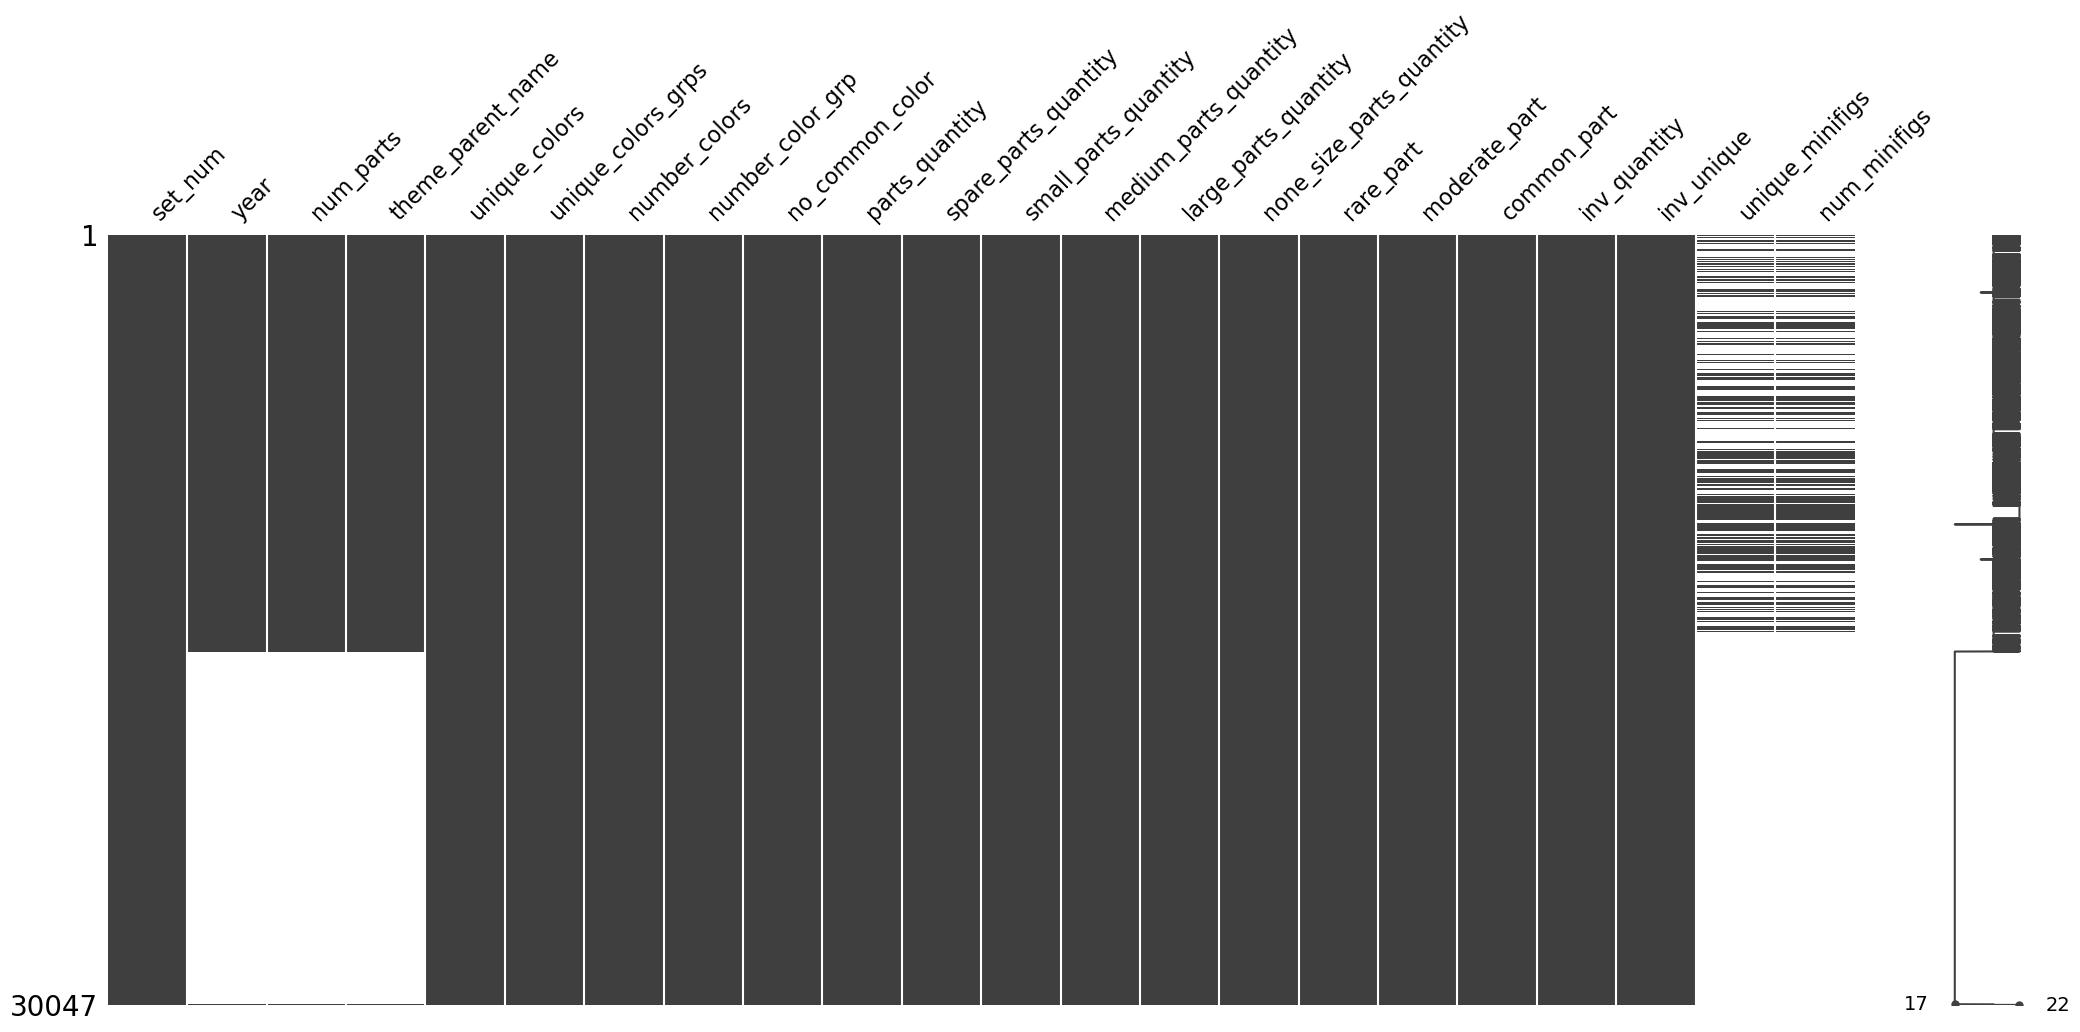

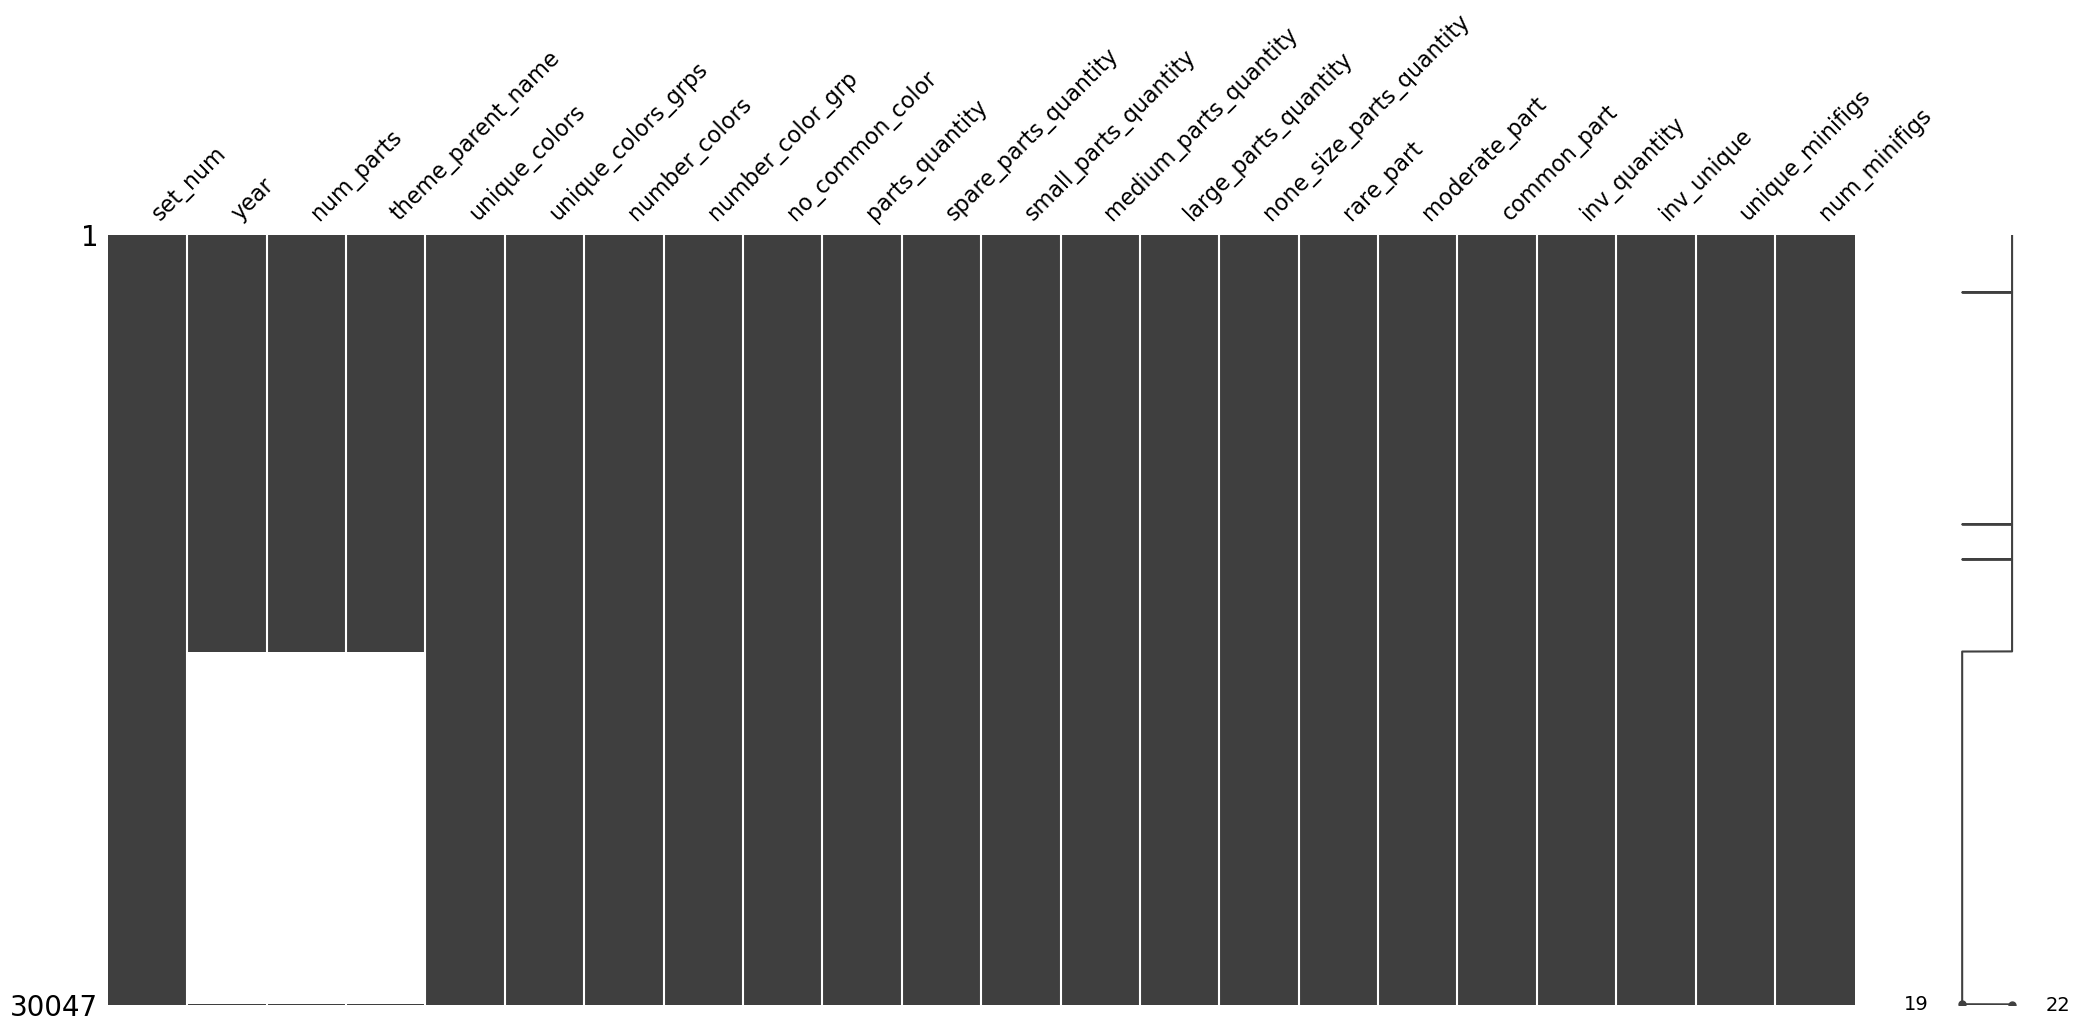

In [61]:
display(msno.matrix(features))
features[['unique_minifigs','num_minifigs']] = features[['unique_minifigs','num_minifigs']].fillna(0)
display(msno.matrix(features))

In [62]:
#if True:
if False:
    all_variables = dict(locals())
    for variable_name, variable_value in all_variables.items():
        if variable_name[:2] in ['df','gr']:
            print(f"{variable_name}")


## Price Dataset

In [63]:
def quick_view_df(df,num=3):
    return pd.concat([df[:num],df[-num:]])

# Read datasets for price  
dataset_price = {}
dataset_price['Price_1'] = pd.read_csv("data\LEGO Sets and Prices Over Time\LEGO Data\sets.csv")
dataset_price['Price_2'] = pd.read_csv("data\LEGO secondary market price data\DiB whole sample prices.csv")
dataset_price['Price_3'] = pd.read_csv("data\marketing price.csv", header=None)

display(dataset_price['Price_1'].head(2)
       ,dataset_price['Price_2'].head(2)
        ,dataset_price['Price_1'].shape,dataset_price['Price_2'].shape
       )


# data pre-processing

#dataset_price['Price_1']['Set_ID'].unique()
#dataset_price['Price_2']['id'].unique()
#dataset_price['Price_1']['Set_ID'].unique()[2] in dataset['sets']['set_num'].unique()

# pre-process set_number in Price_2
temp = dataset_price['Price_2'].copy()
temp['grp'] = temp['id'].apply(lambda x:x[-2])
dataset_price['Price_2'] = temp[~temp['grp'].isin(['D', 'C', 'd'])]
del temp
dataset_price['Price_2'].loc[dataset_price['Price_2']['grp'] != '-','id'] = dataset_price['Price_2'].loc[
    dataset_price['Price_2']['grp'] != '-','id'] .apply(lambda x:x+'-1')
dataset_price['Price_2']['grp'] = dataset_price['Price_2']['id'].apply(lambda x:x[-2])
#dataset_price['Price_2'].head(3)

# select and rename columns
dataset_price['Price_2'] = dataset_price['Price_2'][['id','theme','name','year of release','# of pieces','# of minifigures','Average Price']
                                                   ].dropna(subset=['Average Price'])
# dataset_price['Price_2']['set_number'].nunique() == dataset_price['Price_2'].shape[0]
dataset_price['Price_msrp'] = dataset_price['Price_1'].copy()[['Set_ID','Theme', 'Name', 'Year','Pieces','Minifigures','Current_Price','USD_MSRP']
                               ].dropna(subset=['USD_MSRP']).reset_index(drop = True)
dataset_price['Price_1'] = dataset_price['Price_1'][['Set_ID','Theme', 'Name', 'Year','Pieces','Minifigures','Current_Price','USD_MSRP']
                               ].dropna(subset=['Current_Price'])
dataset_price['Price_1'].columns = ['set_number','theme','name','year','pieces','minifigs','price','msrp']
dataset_price['Price_2'].columns = ['set_number','theme','name','year','pieces','minifigs','price']
display(
    dataset_price['Price_1'].head(2)
    ,dataset_price['Price_2'].head(2)
    ,dataset_price['Price_1'].shape,dataset_price['Price_2'].shape
)

dataset_price['Price_2']['price_2018'] = dataset_price['Price_2']['price']
dataset_price['Price_2']['price'] = dataset_price['Price_2']['price'] * 2.469

,Set_ID,Name,Year,Theme,Theme_Group,Subtheme,Category,Packaging,Num_Instructions,Availability,Pieces,Minifigures,Owned,Rating,USD_MSRP,Total_Quantity,Current_Price
0,75-1,PreSchool Set,1975,PreSchool,Pre-school,NaN,Normal,{Not specified},0,{Not specified},16.0,NaN,10.0,0.0,NaN,NaN,NaN
1,77-1,PreSchool Set,1975,PreSchool,Pre-school,NaN,Normal,{Not specified},0,{Not specified},20.0,NaN,11.0,0.0,NaN,NaN,NaN


,id,theme,name,year of release,# of pieces,# of minifigures,Average Price,1/1/218,1/2/218,1/3/218,...,1/7/218,1/8/218,1/9/218,1/1/218.1,1/11/218,1/12/218,1/1/219,1/2/219,1/3/219,1/4/219
0,10196,Advanced models,Grand Carousel,2009,3263,9.0,1293.05125,1817.53,1686.13,168.47,...,157.87,1436.93,1436.93,1351.00,1351.00,1348.33,1338.33,1338.33,1229.2,1188.7
1,10190,Advanced models,Market Street,2007,1248,3.0,569.78500,996.5,996.5,996.5,...,99.11,8.55,747.33,747.33,677.86,644.53,611.20,549.53,481.2,365.7


(14936, 17)

(2322, 23)

,set_number,theme,name,year,pieces,minifigs,price,msrp
36,659-1,LEGOLAND,Police Patrol,1975,49.0,2.0,55.0000,NaN
71,314-1,LEGOLAND,Police Launch,1976,53.0,2.0,149.2976,NaN


,set_number,theme,name,year,pieces,minifigs,price
0,10196-1,Advanced models,Grand Carousel,2009,3263,9.0,1293.05125
1,10190-1,Advanced models,Market Street,2007,1248,3.0,569.78500


(5442, 8)

(2291, 7)

In [64]:
# compare Price_per_piece in different themes
# Price_1
grp = dataset_price['Price_1'].groupby('theme').agg({'price':['mean','std'],'pieces':'mean'})
grp.columns = ['price','std_price','pieces']
grp['price_per_piece'] = grp['price']/grp['pieces']
grp = grp.reset_index()
quick_view_df(grp.sort_values(by='price_per_piece'),4)

,theme,price,std_price,pieces,price_per_piece
8,Art,125.835855,39.980188,4091.727273,0.030754
41,Dots,9.122027,9.613753,194.625000,0.046870
27,Classic,18.735725,19.209318,338.729167,0.055312
56,Icons,149.887673,149.587668,2133.022222,0.070270
29,Collectable Minifigures,83.357902,80.552321,10.345679,8.057267
85,Powered Up,32.330000,15.949191,3.000000,10.776667
83,Power Functions,38.805006,35.774424,2.166667,17.910003
52,Gear,163.128843,107.087415,NaN,NaN


In [65]:
if False:
    p,q, = 0,0 
    temp = dataset['sets']['set_num'].unique()
    for i in dataset_price['Price_1']['Set_ID'].unique():
        if i in temp:
            p += 1
        else:
            q += 1 
    print(p,q) # 14049 887

# remove temp values
try:
    del (p,q,temp)
except NameError:
    pass

grp = dataset_price['Price_2'].groupby('theme').agg({'price':['mean','std'],'pieces':'mean'})
grp.columns = ['price','std_price','pieces']
grp['price_per_piece'] = grp['price']/grp['pieces']
grp = grp.reset_index()
quick_view_df(grp.sort_values(by='price_per_piece'),2)

,theme,price,std_price,pieces,price_per_piece
40,The Simpsons,517.144395,NaN,2523.000000,0.204972
29,Prince of Persia,68.400816,68.706651,311.666667,0.219468
42,Trains,329.933210,285.710507,375.678571,0.878233
16,Hero factory,70.608014,30.885055,77.407407,0.912161


In [66]:
display(
    dataset_price['Price_2'][dataset_price['Price_2']['theme'] == 'Ideas'][:2]
    ,dataset_price['Price_1'][dataset_price['Price_1']['theme'] == 'Ideas'][:2]
)

,set_number,theme,name,year,pieces,minifigs,price,price_2018
1191,21104-1,Ideas,NASA Mars Science Laboratory Curiosity Rover,2014,295,0.0,339.450465,137.485000
1192,21110-1,Ideas,Research Institute,2014,165,3.0,98.486867,39.889375


,set_number,theme,name,year,pieces,minifigs,price,msrp
9276,21102-1,Ideas,Minecraft Micro World: The Forest,2012,480.0,2.0,52.00,34.99
9505,21103-1,Ideas,The DeLorean Time Machine,2013,401.0,2.0,120.01,34.99


In [67]:
dataset_price['Price_1'] 

,set_number,theme,name,year,pieces,minifigs,price,msrp
36,659-1,LEGOLAND,Police Patrol,1975,49.0,2.0,55.0000,NaN
71,314-1,LEGOLAND,Police Launch,1976,53.0,2.0,149.2976,NaN
74,369-1,LEGOLAND,Coast Guard Station,1976,275.0,5.0,250.0000,NaN
87,485-1,LEGOLAND,Fire Truck,1976,72.0,3.0,165.0000,NaN
174,787-1,Basic,Storage Cloth,1977,1.0,NaN,90.0000,NaN
...,...,...,...,...,...,...,...,...
14896,77015-1,Indiana Jones,Temple of the Golden Idol,2023,1545.0,5.0,170.1470,149.99
14897,80040-1,Monkie Kid,Monkie Kid's Combi Mech,2023,277.0,2.0,32.0000,19.99
14908,112323-1,Ninjago,Master Wu vs. Ghost Archer,2023,12.0,2.0,9.9500,NaN
14922,662302-1,Minecraft,"Cave Explorer, Creeper and Slime",2023,30.0,2.0,7.0000,NaN


In [68]:
temp = dataset_price['Price_1'].merge(dataset_price['Price_2'][['set_number','price']], how = 'outer', on = 'set_number')
temp = temp[temp['price_y'].isna()][['set_number', 'theme', 'name', 'year', 'pieces', 'minifigs', 'price_x']]
temp.rename(columns = {'price_x':'price'}, inplace = True )
dataset_price['Price_1'] = temp.copy()
df_price_small_sample = pd.concat([dataset_price['Price_1'],dataset_price['Price_2'].drop('price_2018', axis=1)])
del temp
dataset_price['small_sample'] = df_price_small_sample
dataset_price['small_sample'] =dataset_price['small_sample'].reset_index()[['set_number', 'theme', 'name', 'year', 'pieces', 'minifigs', 'price']]
dataset_price['small_sample'].tail(3)

,set_number,theme,name,year,pieces,minifigs,price
6159,2159-1,Trains,9V Train Track Starter Collection,2006.0,24.0,0.0,19.585342
6160,4206-1,Trains,9V Train Switching Track Collection,2006.0,27.0,0.0,103.471161
6161,10205-1,Trains,"“Large Train Engine with Tender,Black”",2002.0,232.0,0.0,200.297625


In [69]:
dataset_price['Price_3'].columns = ['price','set_number','url']
dataset_price['Price_3']['price'] = dataset_price['Price_3']['price'].str.replace(',', '')
#dataset_price['Price_3'][-20:]
if dataset_price['Price_3']['price'][0][0] == '$':
    dataset_price['Price_3']['price'] = dataset_price['Price_3']['price'].str.extract(r'\$([\d.]+)')
quick_view_df(dataset_price['Price_3'],5)


,price,set_number,url
0,19.49,10904-1,https://www.brickeconomy.com/set/10904-1/lego-...
1,33.55,Stormbreaker,https://www.brickeconomy.com/set/SID00158280-1...
2,3.81,911948-1,https://www.brickeconomy.com/set/911948-1/lego...
3,21.49,853913-1,https://www.brickeconomy.com/set/853913-1/lego...
4,5.43,40325-1,https://www.brickeconomy.com/set/40325-1/lego-...
6324,139.87,80035-1,https://www.brickeconomy.com/set/80035-1/lego-...
6325,4.43,212118-1,https://www.brickeconomy.com/set/212118-1/lego...
6326,3.41,892182-1,https://www.brickeconomy.com/set/892182-1/lego...
6327,22.02,5007224-1,https://www.brickeconomy.com/set/5007224-1/leg...
6328,14.10,40484-1,https://www.brickeconomy.com/set/40484-1/lego-...


In [70]:
data_to_save = (dataset, df_parts_freq, df_parts_info, dataset_price)

with open(PKL_FILENAME3, 'wb') as file:
    pickle.dump(data_to_save, file)
    

model_data_to_save = (dataset_price,features)

with open(PKL_FILENAME4, 'wb') as file:
    pickle.dump(model_data_to_save, file)

## Some additional EDA after processing

In [71]:
PKL_FILENAME3 = r'data/variables3.pkl'
with open(PKL_FILENAME3, 'rb') as file:
    loaded_data = pickle.load(file)


(dataset, df_parts_freq, df_parts_info, dataset_price) =  loaded_data

In [72]:
df_unique_part_infp = df_parts_info[['cat_name', 'part_num', 'part_name', 'part_cat_id', 'part_material', 'part_shape', 'part_size'
               , 'freq', 'rarity']].drop_duplicates()
temp = df_all.merge(df_unique_part_infp, on = 'part_num', how = 'left').dropna()
temp['size_grp'] = 'none'
temp.loc[(temp['part_size'] >= 1) & (temp['part_size'] <= 2) , 'size_grp']  = 'small'
temp.loc[(temp['part_size'] >= 3) & (temp['part_size'] <= 7) , 'size_grp']  = 'medium'
temp.loc[(temp['part_size'] >= 8) , 'size_grp']  = 'large'

In [73]:
df_all_colors.groupby('name_y').count().sort_values(by = 'rgb', ascending = False)[:15]

,set_num,name_x,year,theme_id,color_id,quantity,rgb,is_trans
name_y,,,,,,,,
Black,199120,199120,199120,199120,199120,199120,199120,199120
White,126190,126190,126190,126190,126190,126190,126190,126190
Light Bluish Gray,122236,122236,122236,122236,122236,122236,122236,122236
Dark Bluish Gray,90193,90193,90193,90193,90193,90193,90193,90193
Red,84492,84492,84492,84492,84492,84492,84492,84492
Yellow,57693,57693,57693,57693,57693,57693,57693,57693
Blue,45184,45184,45184,45184,45184,45184,45184,45184
Reddish Brown,37948,37948,37948,37948,37948,37948,37948,37948
Tan,35089,35089,35089,35089,35089,35089,35089,35089


In [74]:
df_all_colors.groupby('rgb').count().sort_values(by = 'color_id', ascending = False)[:15]

,set_num,name_x,year,theme_id,color_id,quantity,name_y,is_trans
rgb,,,,,,,,
05131D,204108,204108,204108,204108,204108,204108,204108,204108
FFFFFF,126423,126423,126423,126423,126423,126423,126423,126423
A0A5A9,122236,122236,122236,122236,122236,122236,122236,122236
C91A09,93821,93821,93821,93821,93821,93821,93821,93821
6C6E68,90198,90198,90198,90198,90198,90198,90198,90198
F2CD37,57693,57693,57693,57693,57693,57693,57693,57693
0055BF,45184,45184,45184,45184,45184,45184,45184,45184
582A12,37948,37948,37948,37948,37948,37948,37948,37948
E4CD9E,35090,35090,35090,35090,35090,35090,35090,35090


In [75]:
# Convert the 'rarity' column to numerical values, you can use LabelEncoder or a custom mapping
rarity_mapping = {'common': 1, 'moderate': 2, 'rare': 3}
temp['rarity_num'] = temp['rarity'].map(rarity_mapping)

# Calculate the count of each rarity for each year
pivot_table = pd.pivot_table(temp, values='rarity_num', index='year', columns='rarity', aggfunc='count', fill_value=0)
pivot_table['total'] = pivot_table.sum(axis=1)

# Calculate percentages
for rarity in rarity_mapping.keys():
    pivot_table[rarity + '_percentage'] = pivot_table[rarity] / pivot_table['total'] * 100

fig = go.Figure()

for i, rarity in enumerate(rarity_mapping.keys()):
    fig.add_trace(go.Bar(
        x=pivot_table.index,
        y=pivot_table[rarity + '_percentage'],
        name=rarity,
        marker_color=px.colors.qualitative.Set2[i] 
    ))

fig.update_layout(
    barmode='stack',
    title='Part Rarity Distribution Over Years', title_x=0.5,
    xaxis=dict(title='Year',tickfont=dict(size=12)),
    yaxis=dict(title='Percentage',tickfont=dict(size=12)),
    legend=dict(title='Rarity', font=dict(size=12)),  
    width=800,  
    height=330, 
)

if SHOW_FIG:
    fig.show()
EDA_rarity = fig 
plot_file('EDA_rarity')

*****

Output html fig EDA_rarity

*****


In [76]:
temp.groupby('size_grp').count()

,index,set_num,version,name_x,year,theme_id,num_parts,img_url_x,inventory_id,part_num,...,is_trans,cat_name,part_name,part_cat_id,part_material,part_shape,part_size,freq,rarity,rarity_num
size_grp,,,,,,,,,,,,,,,,,,,,,
large,108753,108753,108753,108753,108753,108753,108753,108753,108753,108753,...,108753,108753,108753,108753,108753,108753,108753,108753,108753,108753
medium,99722,99722,99722,99722,99722,99722,99722,99722,99722,99722,...,99722,99722,99722,99722,99722,99722,99722,99722,99722,99722
none,85,85,85,85,85,85,85,85,85,85,...,85,85,85,85,85,85,85,85,85,85
small,126911,126911,126911,126911,126911,126911,126911,126911,126911,126911,...,126911,126911,126911,126911,126911,126911,126911,126911,126911,126911


In [77]:
# Convert the 'rarity' column to numerical values, you can use LabelEncoder or a custom mapping
size_mapping = {'large':3, 'medium':2, 'small':1}
temp['size_num'] = temp['size_grp'].map(size_mapping)

# Calculate the count of each rarity for each year
pivot_table = pd.pivot_table(temp, values='size_num', index='year', columns='size_grp', aggfunc='count', fill_value=0)
pivot_table['total'] = pivot_table.sum(axis=1)

# Calculate percentages
for rarity in size_mapping.keys():
    pivot_table[rarity + '_percentage'] = pivot_table[rarity] / pivot_table['total'] * 100

fig = go.Figure()

for i, rarity in enumerate(size_mapping.keys()):
    fig.add_trace(go.Bar(
        x=pivot_table.index,
        y=pivot_table[rarity + '_percentage'],
        name=rarity,
        marker_color=px.colors.qualitative.Set2[i] 
    ))


fig.update_layout(
    barmode='stack',
    title='Part Size Distribution Over Years', title_x=0.5,
    xaxis=dict(title='Year',tickfont=dict(size=12)),
    yaxis=dict(title='Percentage',tickfont=dict(size=12)),
    legend=dict(title='Size', font=dict(size=12)),  
    width=800,  
    height=330, 
)

if SHOW_FIG:
    fig.show()
EDA_size = fig 
plot_file('EDA_size')

*****

Output html fig EDA_size

*****
